<a href="https://colab.research.google.com/github/dounia-sad/oct_ai/blob/main/oct_deeplearning_research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# installation of library non native to Colab
!pip install wget scikit-plot --quiet

In [ ]:
import datetime
import os
import shutil
import zipfile
from math import floor
from random import shuffle

import keras
import matplotlib.pyplot as plt
import numpy as np
import scipy
import seaborn as sns
import tensorflow
import wget
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    cohen_kappa_score,
    confusion_matrix,
    RocCurveDisplay
)
from tensorflow.data import AUTOTUNE
from tensorflow.keras import Sequential
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import (
    CSVLogger,
    EarlyStopping,
    ModelCheckpoint,
    TensorBoard,
)
from tensorflow.keras.layers import Dense, Flatten, Input, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.metrics import (
    AUC,
    Accuracy,
    BinaryAccuracy,
    CategoricalAccuracy,
    F1Score,
    FalseNegatives,
    FalsePositives,
    MeanAbsoluteError,
    Precision,
    PrecisionAtRecall,
    R2Score,
    Recall,
    RecallAtPrecision,
    RootMeanSquaredError,
    SensitivityAtSpecificity,
    SpecificityAtSensitivity,
    TrueNegatives,
    TruePositives,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [ ]:
# display version of Python, Tensorflow, Keras and GPU status
!python --version

print(f"Tensorflow Version: {tensorflow.__version__}")
print(f"Keras Version: {keras.__version__}")
print(f"Scipy Version: {scipy.__version__}")
print("GPU Available:", tensorflow.config.list_physical_devices(device_type="GPU"))

Python 3.10.12
Tensorflow Version: 2.17.0
Keras Version: 3.4.1
Scipy Version: 1.13.1
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
CLASSES = ["NORMAL", "CNV", "DRUSEN", "DME"]  # classes for the multicategorical model
CLASSES_NORMAL_CNV = ["NORMAL", "CNV"]  # classes for binary model normal vs cnv
CLASSES_NORMAL_DRUSEN = [
    "NORMAL",
    "DRUSEN",
]  # classes for binary model normal vs drusen
CLASSES_NORMAL_DME = ["NORMAL", "DME"]  # classes for binary model normal vs dme
IMG_SIZE = 200
VALIDATION_SPLIT = 0.20
RANDOM_STATE = 30
NUM_EPOCHS = 50
TRAIN_BATCH_SIZE = 16
VALIDATION_BATCH_SIZE = 16
TEST_BATCH_SIZE = 50

In [ ]:
# we create a timestamp referene that will be used when saving our various files (weights, models,metrics,..)
time_stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M")
octai_model_version = f"{time_stamp}_octai_model"
octai_model_version

'20240908-1027_octai_model'

In [ ]:
# various files path taht will be used to save our data
dl_data_dir = "CellData/OCT/"
raw_dir = "raw_oct_data/"
data_dir = "model_oct_data/"

In [ ]:
# check if data already downloaded
dowload_data = False if os.path.isdir(dl_data_dir) else True

In [ ]:
if dowload_data:

    # URL for the DOI 10.17632/rscbjbr9sj.3 from Mendeley Data
    octai_ulr = "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/rscbjbr9sj-3.zip"

    server_zip = wget.download(octai_ulr)

    # we check if the file downloaded is a zip file
    zipfile.is_zipfile(filename=server_zip)

    # we extract the zip file from the server
    with zipfile.ZipFile(file=server_zip) as zip_ref:
        zip_ref.extractall()

    # we extract the name of the zhang lab data zip file insite the zip file
    zhang_lab_data_zip = list(zipfile.ZipFile(file=server_zip).namelist())[0]

    # we check if the zhang lab datafile downloaded is a zip file
    zipfile.is_zipfile(filename=zhang_lab_data_zip)

    # we extract from the zhang lab data only the OTC scans
    zipdata = zipfile.ZipFile(file=zhang_lab_data_zip)
    for file in zipdata.namelist():
        if file.startswith(dl_data_dir):
            zipdata.extract(member=file)

    # create raw dir file
    os.makedirs(name=os.path.join(raw_dir))

    # we copy all the files from test and train in a new folder called raw_oct_data
    for sub_folder in os.listdir(path=dl_data_dir):
        sub_folder_path = os.path.join(dl_data_dir, sub_folder)
        shutil.copytree(src=sub_folder_path, dst=raw_dir, dirs_exist_ok=True)
        print(f"directory {sub_folder_path} copied to {raw_dir}")

# we delete the all zip files to free space
!rm -d *.zip

directory CellData/OCT/test copied to raw_oct_data/
directory CellData/OCT/train copied to raw_oct_data/


In [ ]:
# we define the train/test/split ratio
train_ratio = 0.70
validation_ratio = 0.20
test_ratio = 0.10


# create a small functions that restur list the -jpeg files in a folder
def get_file_list_from_dir(datadir):
    all_files = os.listdir(path=os.path.abspath(path=datadir))
    data_files = list(filter(lambda file: file.endswith(".jpeg"), all_files))
    return data_files


# create sub folder for train/val/test
for dir in ["train", "val", "test"]:
    for _class in os.listdir(path=raw_dir):
        os.makedirs(name=os.path.join(data_dir, dir, _class))

for _class in os.listdir(path=raw_dir):
    class_list = get_file_list_from_dir(datadir=os.path.join(raw_dir, _class))

    # we shuffle the images of the class
    shuffle(x=class_list)

    # we compute the split indices to respect our ratios
    first_split_index = floor(len(class_list) * train_ratio)
    second_split_index = floor(len(class_list) * (train_ratio + validation_ratio))

    train_files = class_list[:first_split_index]
    val_files = class_list[first_split_index:second_split_index]
    test_files = class_list[second_split_index:]

    # we copy our data in the respective destination files
    for file in train_files:
        shutil.copy(
            src=os.path.join(raw_dir, _class, file),
            dst=os.path.join(data_dir, "train", _class, file),
        )

    for file in val_files:
        shutil.copy(
            src=os.path.join(raw_dir, _class, file),
            dst=os.path.join(data_dir, "val", _class, file),
        )

    for file in test_files:
        shutil.copy(
            src=os.path.join(raw_dir, _class, file),
            dst=os.path.join(data_dir, "test", _class, file),
        )

In [ ]:
# we parse our folder structure to count the images per class and for each sub folder train/val/test
file_structure = dict()
classes_count = dict()
classes = []
for sub_cat in os.listdir(path=data_dir):
    file_structure[sub_cat] = {"total": 0}
    for _class in os.listdir(path=os.path.join(data_dir, sub_cat)):
        nb_images = len(os.listdir(path=os.path.join(data_dir, sub_cat, _class)))
        file_structure[sub_cat].update({_class: nb_images})
        file_structure[sub_cat]["total"] += nb_images
        classes.append(_class) if _class not in classes else None

nb_img_train = file_structure["train"]["total"]
nb_img_val = file_structure["val"]["total"]
nb_img_test = file_structure["test"]["total"]
nb_img_total = sum([file_structure[x]["total"] for x in file_structure])

file_structure

{'val': {'total': 21861,
  'DRUSEN': 1773,
  'NORMAL': 10277,
  'DME': 2320,
  'CNV': 7491},
 'test': {'total': 10933,
  'DRUSEN': 887,
  'NORMAL': 5140,
  'DME': 1160,
  'CNV': 3746},
 'train': {'total': 76515,
  'DRUSEN': 6206,
  'NORMAL': 35973,
  'DME': 8118,
  'CNV': 26218}}

In [ ]:
# we store the path of the train, validation and test direcorties
train_dir = os.path.join(data_dir + "train/")
val_dir = os.path.join(data_dir + "val/")
test_dir = os.path.join(data_dir + "test/")

In [ ]:
# we print the number of images per train/val/test folder
print(f"Number of images in train: {nb_img_train}")
print(f"Number of images in val: {nb_img_val}")
print(f"Number of images in test: {nb_img_test}")
print(f"Number total of images: {nb_img_total}")

Number of images in train: 76515
Number of images in val: 21861
Number of images in test: 10933
Number total of images: 109309


In [ ]:
# we count total number of images per class
classes_count = {_class: 0 for _class in classes}
for _, v in file_structure.items():
    for _class in classes:
        classes_count[_class] += v[_class]

# we compute the weights of each class and store them for later use in the multiclass model
_class_weight = {k: (v / nb_img_total) for k, v in classes_count.items()}
total_weight = 0
for _class, weight in _class_weight.items():
    print(f"Weight of class {_class}: {weight:0.2%}")
    total_weight += weight

print(f"Total weight: {total_weight:0.2%}")
print(classes_count)

Weight of class DRUSEN: 8.11%
Weight of class NORMAL: 47.01%
Weight of class DME: 10.61%
Weight of class CNV: 34.27%
Total weight: 100.00%
{'DRUSEN': 8866, 'NORMAL': 51390, 'DME': 11598, 'CNV': 37455}


In [ ]:
# we compute the weight for each binary class and store them for later use in the binary models
binary_total = sum(v for k, v in classes_count.items() if k in CLASSES_NORMAL_CNV)
weigth_binary_normal_cnv = {
    k: v / binary_total for k, v in classes_count.items() if k in CLASSES_NORMAL_CNV
}

binary_total = sum(v for k, v in classes_count.items() if k in CLASSES_NORMAL_DRUSEN)
weigth_binary_normal_drusen = {
    k: v / binary_total for k, v in classes_count.items() if k in CLASSES_NORMAL_DRUSEN
}

binary_total = sum(v for k, v in classes_count.items() if k in CLASSES_NORMAL_DME)
weigth_binary_normal_dme = {
    k: v / binary_total for k, v in classes_count.items() if k in CLASSES_NORMAL_DME
}

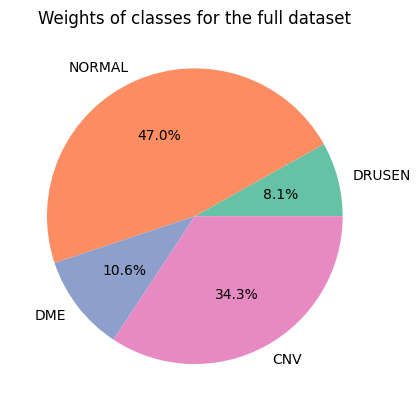

In [ ]:
# we display the total weights per class
palette_color = sns.color_palette(palette="Set2", n_colors=4)
_title = "Weights of classes for the full dataset"
plt.title(label=_title)
plt.pie(
    x=classes_count.values(),
    labels=classes_count.keys(),
    autopct="%1.1f%%",
    colors=palette_color,
)
plt.show()

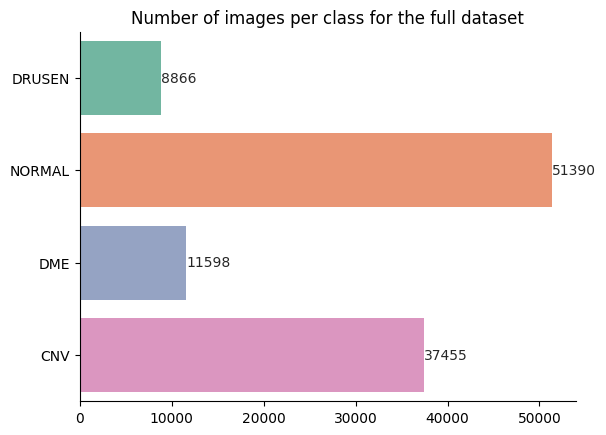

In [ ]:
# we display the total number of images per class
_title = "Number of images per class for the full dataset"
ax = sns.barplot(
    x=list(classes_count.values()),
    y=list(classes_count.keys()),
    palette=palette_color,
    hue=list(classes_count.keys()),
)
sns.set_style(style="whitegrid")
ax.set_title(label=_title)
for container in ax.containers:
    ax.bar_label(container=container)
sns.despine()

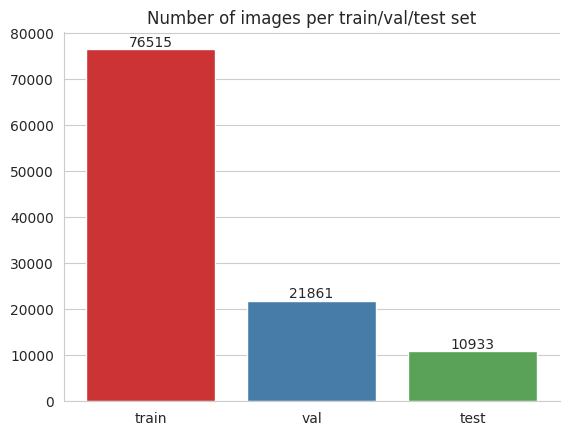

In [ ]:
# we display the number of image per train/val/test set
_title = "Number of images per train/val/test set"
sns.set_style(style="whitegrid")
palette_color_2 = sns.color_palette(palette="Set1", n_colors=3)
ax = sns.barplot(
    x=["train", "val", "test"],
    y=[
        nb_img_train,
        nb_img_val,
        nb_img_test,
    ],
    palette=palette_color_2,
    hue=["train", "val", "test"],
)
ax.set_title(label=_title)
for container in ax.containers:
    ax.bar_label(container=container)
ax.plot()
sns.despine()

In [ ]:
# we compute the class distribution for each train/val/test folder
train_distribution = {
    k: v for k, v in file_structure["train"].items() if k in classes_count.keys()
}
val_distribution = {
    k: v for k, v in file_structure["val"].items() if k in classes_count.keys()
}
test_distribution = {
    k: v for k, v in file_structure["test"].items() if k in classes_count.keys()
}

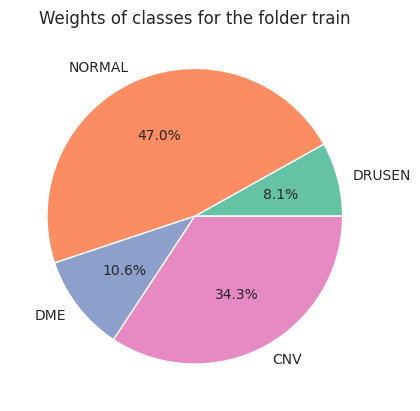

In [ ]:
_title = "Weights of classes for the folder train"
plt.title(label=_title)
plt.pie(
    x=train_distribution.values(),
    labels=train_distribution.keys(),
    autopct="%1.1f%%",
    colors=palette_color,
)
plt.show()

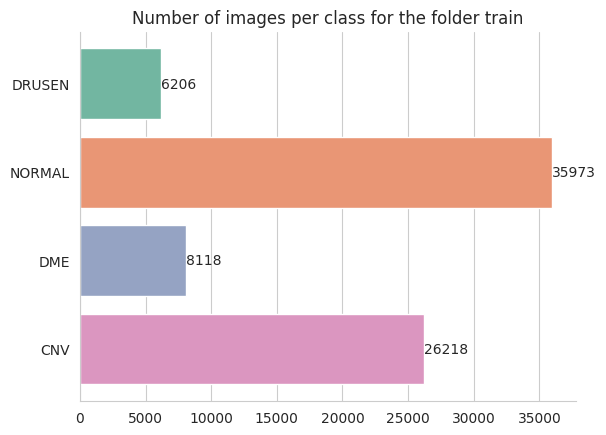

In [ ]:
_title = "Number of images per class for the folder train"
sns.set_style(style="whitegrid")
ax = sns.barplot(
    x=list(train_distribution.values()),
    y=list(train_distribution.keys()),
    palette=palette_color,
    hue=list(train_distribution.keys()),
)
ax.set_title(label=_title)
for container in ax.containers:
    ax.bar_label(container=container)
ax.plot()
sns.despine()

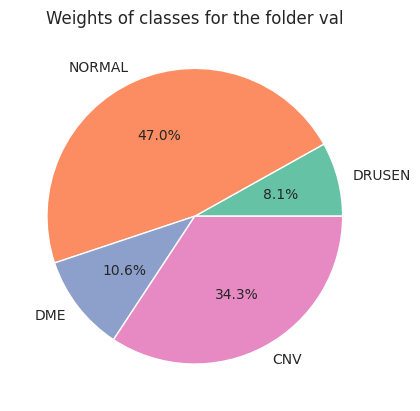

In [ ]:
_title = "Weights of classes for the folder val"
plt.title(label=_title)
plt.pie(
    x=val_distribution.values(),
    labels=val_distribution.keys(),
    autopct="%1.1f%%",
    colors=palette_color,
)
plt.show()

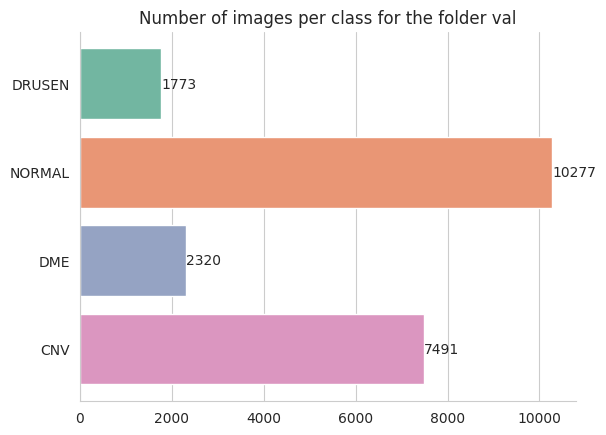

In [ ]:
_title = "Number of images per class for the folder val"
sns.set_style(style="whitegrid")
ax = sns.barplot(
    x=list(val_distribution.values()),
    y=list(val_distribution.keys()),
    palette=palette_color,
    hue=list(val_distribution.keys()),
)
ax.set_title(label=_title)
for container in ax.containers:
    ax.bar_label(container=container)
ax.plot()
sns.despine()

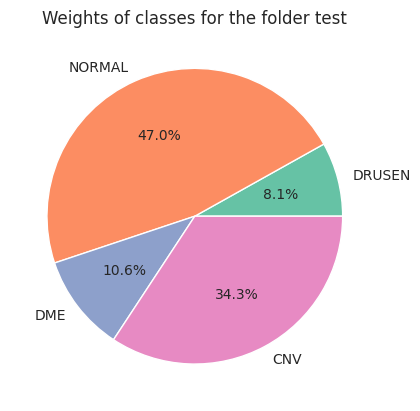

In [ ]:
_title = "Weights of classes for the folder test"
plt.title(label=_title)
plt.pie(
    x=test_distribution.values(),
    labels=test_distribution.keys(),
    autopct="%1.1f%%",
    colors=palette_color,
)
plt.show()

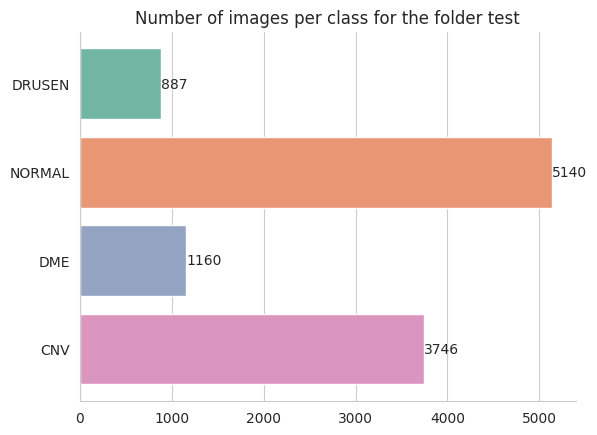

In [ ]:
_title = "Number of images per class for the folder test"
sns.set_style(style="whitegrid")
ax = sns.barplot(
    x=list(test_distribution.values()),
    y=list(test_distribution.keys()),
    palette=palette_color,
    hue=list(test_distribution.keys()),
)
ax.set_title(label=_title)
for container in ax.containers:
    ax.bar_label(container=container)
ax.plot()
sns.despine()

In [ ]:
# we instentiate our VGG19 model with imagenet weights
model_vgg19 = VGG19(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# we freeze the layers of our model and make is non trainable (no update in weights)
model_vgg19.trainable = False

In [ ]:
# we create our custom octai_model using transfer learning technique
model_octai = Sequential(
    [
        Input((IMG_SIZE, IMG_SIZE, 3)),
        Rescaling(1.0 / 255.0),
        model_vgg19,
        Flatten(),
        Dense(len(CLASSES), activation="softmax"),
    ]
)

In [ ]:
# we create our tensor board to further analyze the model via Tensorboard
tensoboard_log_dir = f"../{octai_model_version}"
tensorboard_callback = TensorBoard()

# we save the log training of our model
csv_logger_callback = CSVLogger(
    f"../{octai_model_version}_training_logger.log", separator=",", append=False
)
model_checkpoint = ModelCheckpoint(filepath="model.{epoch:02d}-{val_loss:.2f}.keras")

In [ ]:
"""we define a list of metrics we would like to keep track off during the traning
and be analysed further to asses the model strenght"""

model_metrics = [
    CategoricalAccuracy(),
    AUC(),
    F1Score(),
    Precision(),
    Recall(),
    Accuracy(),
    RootMeanSquaredError(),
    R2Score(),
    MeanAbsoluteError(),
    TruePositives(),
    TrueNegatives(),
    FalsePositives(),
    FalseNegatives(),
    PrecisionAtRecall(0.5),
    RecallAtPrecision(0.5),
    SensitivityAtSpecificity(0.5),
    SpecificityAtSensitivity(0.5),
]

In [ ]:
# we definie our EarlyStopping function to trigger during the training
early_stopping = EarlyStopping(
    monitor="val_loss", verbose=1, patience=5, restore_best_weights=True
)

In [ ]:
# we compile and build our custom model
model_octai.compile(
    loss=CategoricalCrossentropy(), optimizer=Adam(), metrics=model_metrics
)
model_octai.build()

# we display the summary of our custom training
model_octai.summary(show_trainable=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ rescaling (Rescaling)               │ (None, 200, 200, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ vgg19 (Functional)                  │ (None, 6, 6, 512)            │    20,024,384 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ flatten (Flatten)                   │ (None, 18432)                │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense (Dense)                       │ (None, 4)                    │        73,732 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 20,098,116 (76.67 MB)

 Trainable params: 73,732 (288.02 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
# we load our training data via a generator to feed our our model
train_ds = keras.utils.image_dataset_from_directory(
    label_mode="categorical",
    directory=train_dir,
    batch_size=TRAIN_BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
)

Found 76515 files belonging to 4 classes.


In [ ]:
# we load our validation data via a generator to feed our our model
val_ds = keras.utils.image_dataset_from_directory(
    label_mode="categorical",
    directory=val_dir,
    batch_size=VALIDATION_BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
)

Found 21861 files belonging to 4 classes.


In [ ]:
# we use keras functionality to optmise the memory and GPU during the feed of the data
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# we definie the weights of each class in a variable to be given to the model
_class_number = {0: "NORMAL", 1: "CNV", 2: "DRUSEN", 3: "DME"}
_class_weight_model = {k: _class_weight[v] for k, v in _class_number.items()}
_class_weight_model

{0: 0.4701351215361956,
 1: 0.3426524805825687,
 2: 0.08110951522747441,
 3: 0.10610288265376136}

In [ ]:
# we start the training of our model
history_vgg = model_octai.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stopping, csv_logger_callback, tensorboard_callback],
    class_weight=_class_weight_model,
    validation_batch_size=VALIDATION_BATCH_SIZE,
)

Epoch 1/50
4783/4783 ━━━━━━━━━━━━━━━━━━━━ 564s 118ms/step - accuracy: 1.1946e-04 - auc: 0.9382 - categorical_accuracy: 0.8003 - f1_score: 0.6259 - false_negatives: 7324.5933 - false_positives: 6117.2969 - loss: 0.1070 - mean_absolute_error: 0.1210 - precision: 0.8173 - precision_at_recall: 0.9246 - r2_score: 0.4158 - recall: 0.7847 - recall_at_precision: 0.9454 - root_mean_squared_error: 0.2725 - sensitivity_at_specificity: 0.9683 - specificity_at_sensitivity: 0.9849 - true_negatives: 108722.6797 - true_positives: 30955.3984 - val_accuracy: 5.7179e-04 - val_auc: 0.9513 - val_categorical_accuracy: 0.8210 - val_f1_score: 0.6392 - val_false_negatives: 4004.0000 - val_false_positives: 3707.0000 - val_loss: 0.6146 - val_mean_absolute_error: 0.1029 - val_precision: 0.8281 - val_precision_at_recall: 0.9390 - val_r2_score: 0.4342 - val_recall: 0.8168 - val_recall_at_precision: 0.9711 - val_root_mean_squared_error: 0.2638 - val_sensitivity_at_specificity: 0.9711 - val_specificity_at_sensitivity

In [ ]:
# we save our trained model
model_octai.save(f"{octai_model_version}.keras")

# serialize model to JSON
model_json = model_octai.to_json()
with open(file=f"{octai_model_version}.json", mode="w") as json_file:
    json_file.write(model_json)

# we save model weights in a HDF5 file
model_octai.save_weights(f"{octai_model_version}.weights.h5")

In [ ]:
# we define the metrics we chose to display
display_metrics = [
    "accuracy",
    "auc",
    "categorical_accuracy",
    "loss",
    "mean_absolute_error",
    "precision",
    "precision_at_recall",
    "r2_score",
    "recall",
    "recall_at_precision",
    "root_mean_squared_error",
    "sensitivity_at_specificity",
    "specificity_at_sensitivity",
]
display_metrics = [m for m in history_vgg.history.keys() if "val_" not in m]
display_metrics = [m for m in display_metrics if "f1_" not in m]

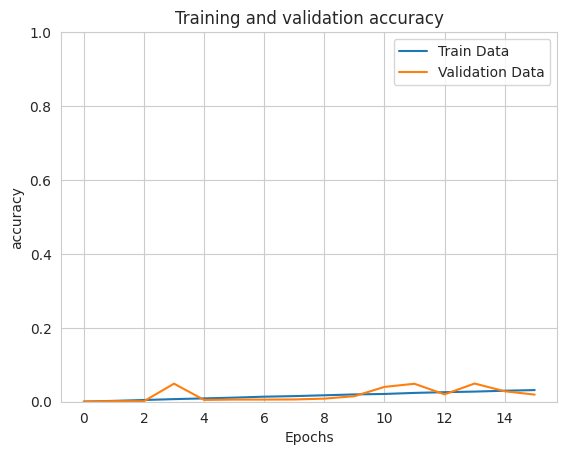

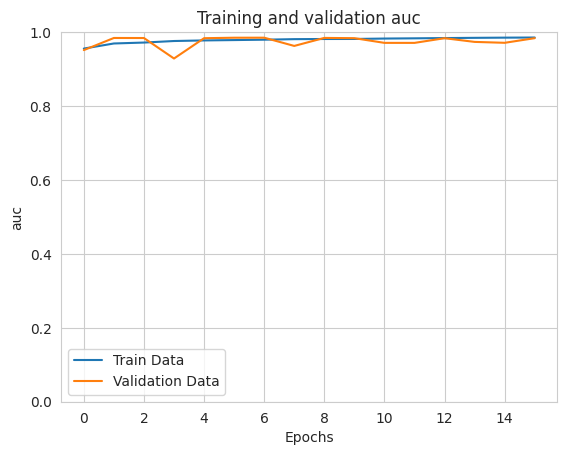

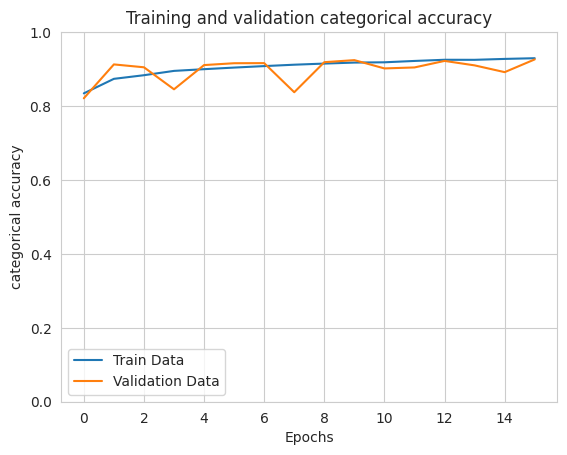

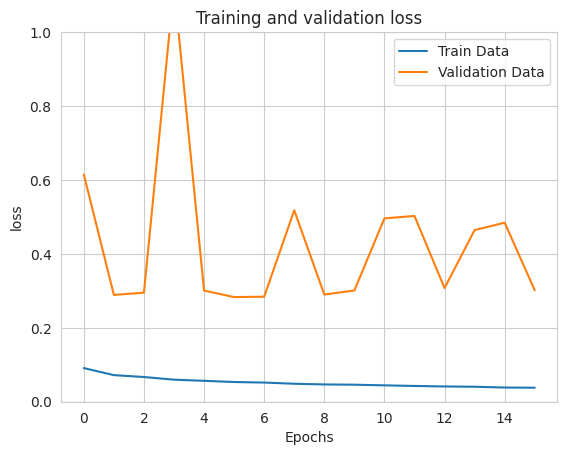

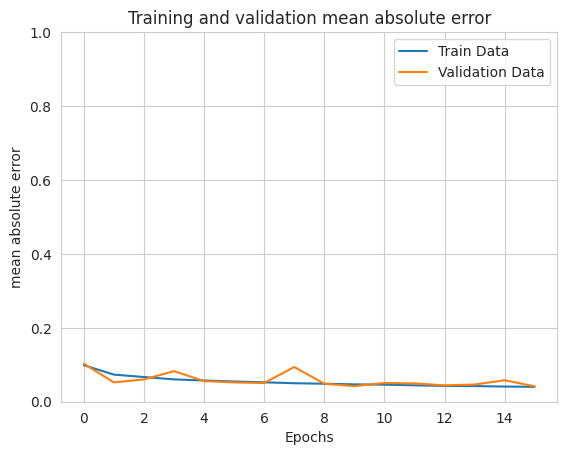

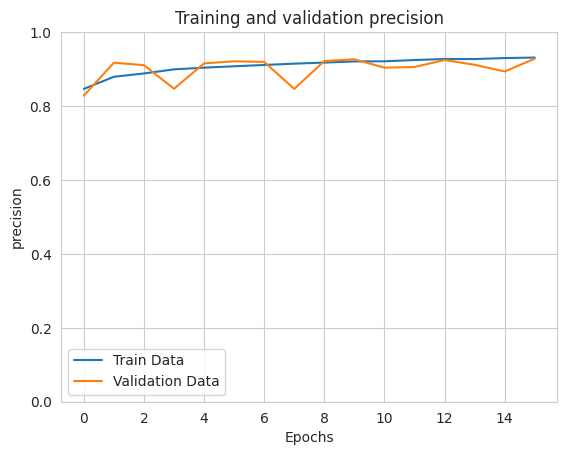

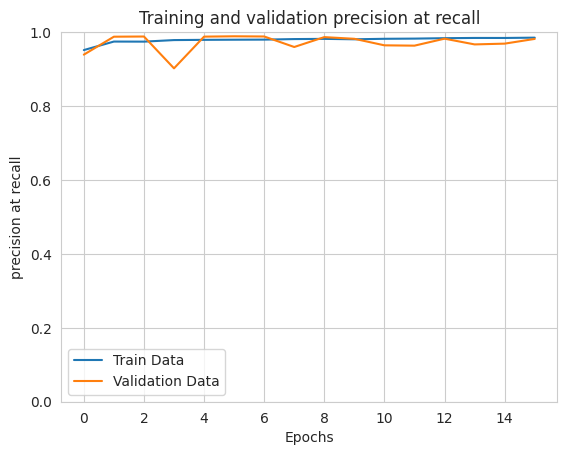

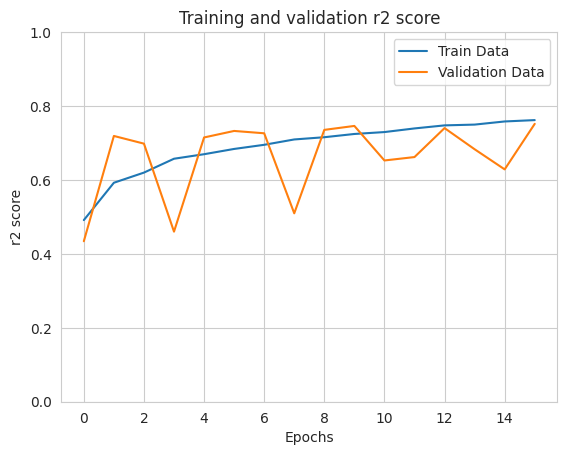

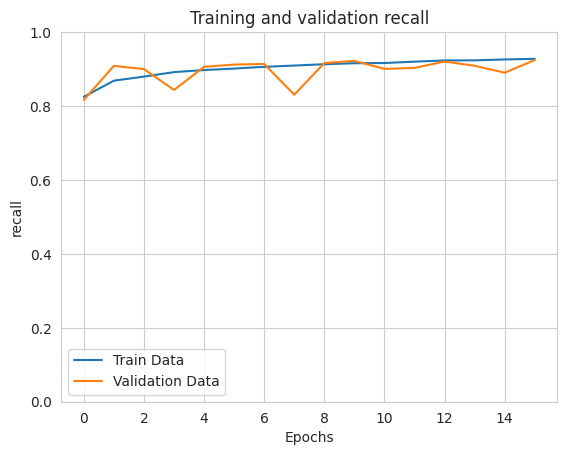

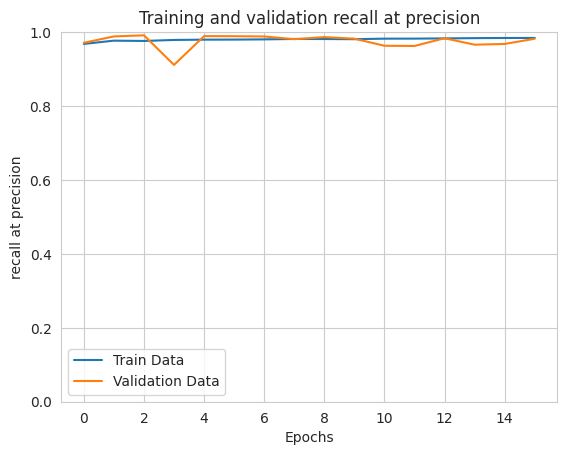

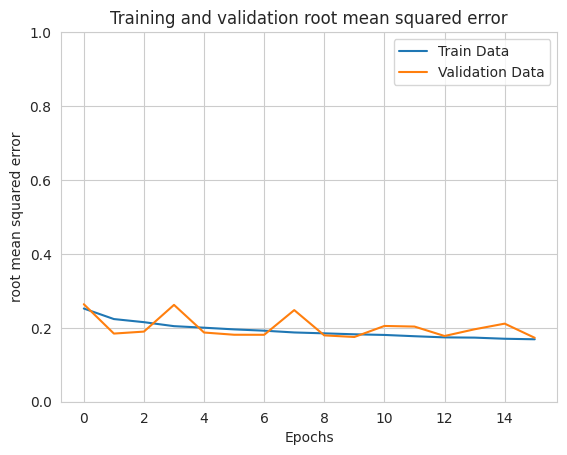

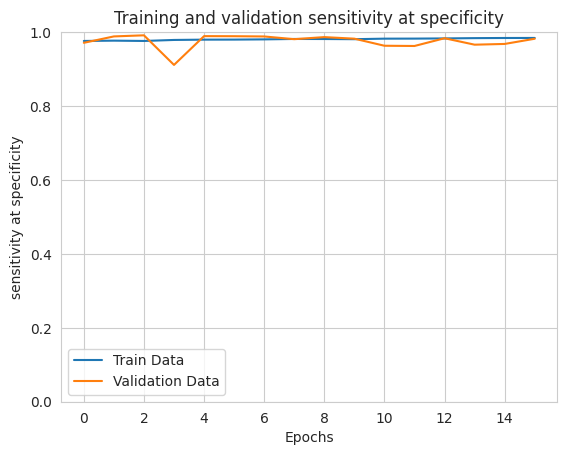

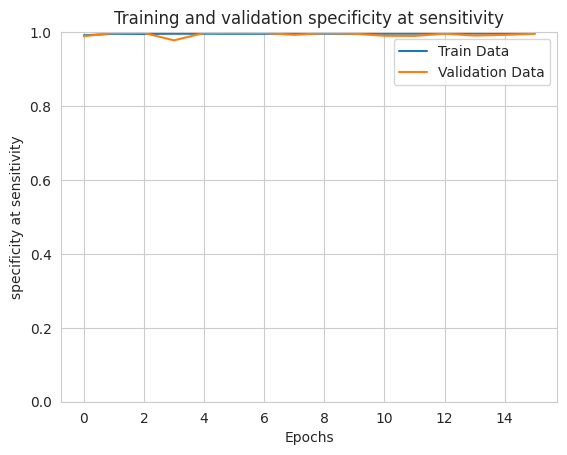

In [ ]:
# we diplay a graph for all the metrics we chose to display
plt.rcParams["axes.grid"] = True
for train_metric_name, train_metric_value in history_vgg.history.items():
    if train_metric_name in display_metrics:
        val_metric_name = "val_" + train_metric_name

        train_metric_data = dict(
            zip(
                range(len(history_vgg.history[train_metric_name])),
                history_vgg.history[train_metric_name],
            )
        )
        val_metric_data = dict(
            zip(
                range(len(history_vgg.history[val_metric_name])),
                history_vgg.history[val_metric_name],
            )
        )
        sns.lineplot(
            data=train_metric_data,
            x=train_metric_data.keys(),
            y=train_metric_data.values(),
            label="Train Data",
        )
        sns.lineplot(
            data=val_metric_data,
            x=val_metric_data.keys(),
            y=val_metric_data.values(),
            label="Validation Data",
        )
        ax = plt.gca()
        ax.set_ylim(bottom=[0, 1])
        plt.xlabel(xlabel="Epochs")
        metric = train_metric_name.replace("_", " ")
        plt.ylabel(ylabel=metric)
        plt.title(label=f"Training and validation {metric}")
        plt.legend()
        plt.show()
        print("")

In [ ]:
# we load our test data via a generator to test the accuary of our model
test_ds = keras.utils.image_dataset_from_directory(
    label_mode="categorical",
    directory=test_dir,
    batch_size=TEST_BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=False,
)

In [ ]:
# we evaluate our trained model using our test data
baseline_results = model_octai.evaluate(test_ds)

In [ ]:
# we print the metrics of our trained model based on our test data
for name, value in zip(
    ["loss"] + [metric.name for metric in model_metrics], baseline_results
):
    print(name, ": ", value)

loss :  0.28742796182632446
categorical_accuracy :  0.9140217900276184
auc :  0.9845112562179565
f1_score :  tf.Tensor([0.94226027 0.838929   0.66112757 0.9520798 ], shape=(4,), dtype=float32)
precision :  0.918427586555481
recall :  0.9103631377220154
accuracy :  0.0066770329140126705
root_mean_squared_error :  0.1823711097240448
r2_score :  0.7267706394195557
mean_absolute_error :  0.05223292484879494
true_positives :  9953.0
true_negatives :  31915.0
false_positives :  884.0
false_negatives :  980.0
precision_at_recall :  0.9889607429504395
recall_at_precision :  0.9882923364639282
sensitivity_at_specificity :  0.9882923364639282
specificity_at_sensitivity :  0.9978657960891724


In [ ]:
# we compute predictions to compute additional metrics
predictions = model_octai.predict(test_ds)

219/219 ━━━━━━━━━━━━━━━━━━━━ 52s 236ms/step


In [ ]:
predicted_classes = np.argmax(a=predictions, axis=1)

true_classes = tensorflow.concat(values=[y for _, y in test_ds], axis=0)
true_classes = np.argmax(true_classes, axis=1)

array([0, 0, 0, ..., 3, 3, 3])

In [ ]:
# we compute the confusition matrix
cm_normalized = confusion_matrix(
    y_true=predicted_classes, y_pred=true_classes, normalize="true"
)
cm = confusion_matrix(y_true=predicted_classes, y_pred=true_classes)

In [ ]:
test_classification_report = classification_report(
    y_true=true_classes, y_pred=predicted_classes
)
print(test_classification_report)

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      3746
           1       0.83      0.85      0.84      1160
           2       0.70      0.63      0.66       887
           3       0.97      0.94      0.95      5140

    accuracy                           0.91     10933
   macro avg       0.85      0.85      0.85     10933
weighted avg       0.91      0.91      0.91     10933



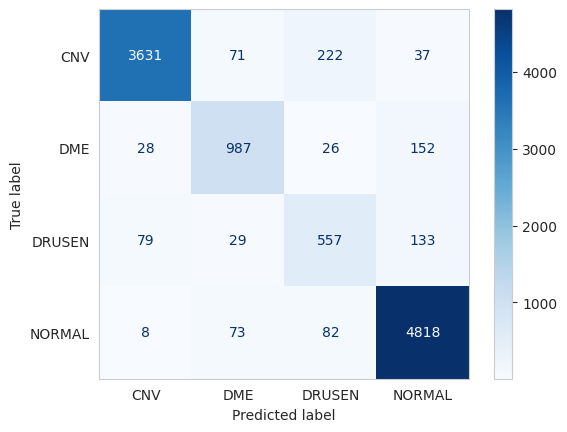

In [ ]:
# we print the confusion matrix
plt.rcParams["axes.grid"] = False
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_ds.class_names)
disp = disp.plot(cmap=plt.cm.Blues)
plt.show()

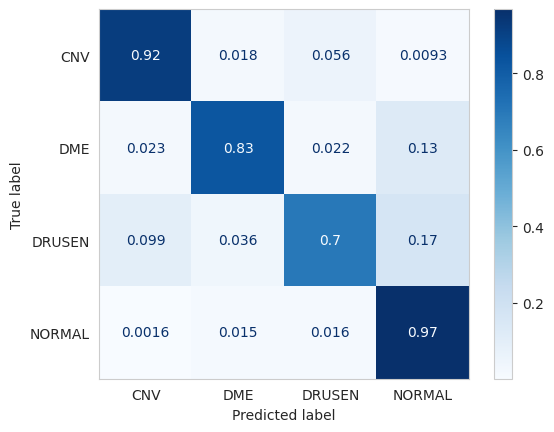

In [ ]:
# we print the confusion matrix normalised
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_normalized, display_labels=test_ds.class_names
)
disp = disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
"""RocCurveDisplay, roc_auc_score, log_loss"""

'RocCurveDisplay, roc_auc_score, log_loss'

In [ ]:
# we compute the cohen_kapp score
cohen_kappa = cohen_kappa_score(y1=true_classes, y2=predicted_classes)
cohen_kappa

NameError: name 'true_classes' is not defined

In [ ]:
"""roc_auc_ovo = roc_auc_score(y_true=true_classes, y_score=predicted_classes, multi_class="ovo")"""

'roc_auc_ovo = roc_auc_score(y_true=true_classes, y_score=predicted_classes, multi_class="ovo")'

In [ ]:
"""roc_auc_ovr = roc_auc_score(y_true=true_classes, y_score=predicted_classes, multi_class="ovr")"""

'roc_auc_ovr = roc_auc_score(y_true=true_classes, y_score=predicted_classes, multi_class="ovr")'

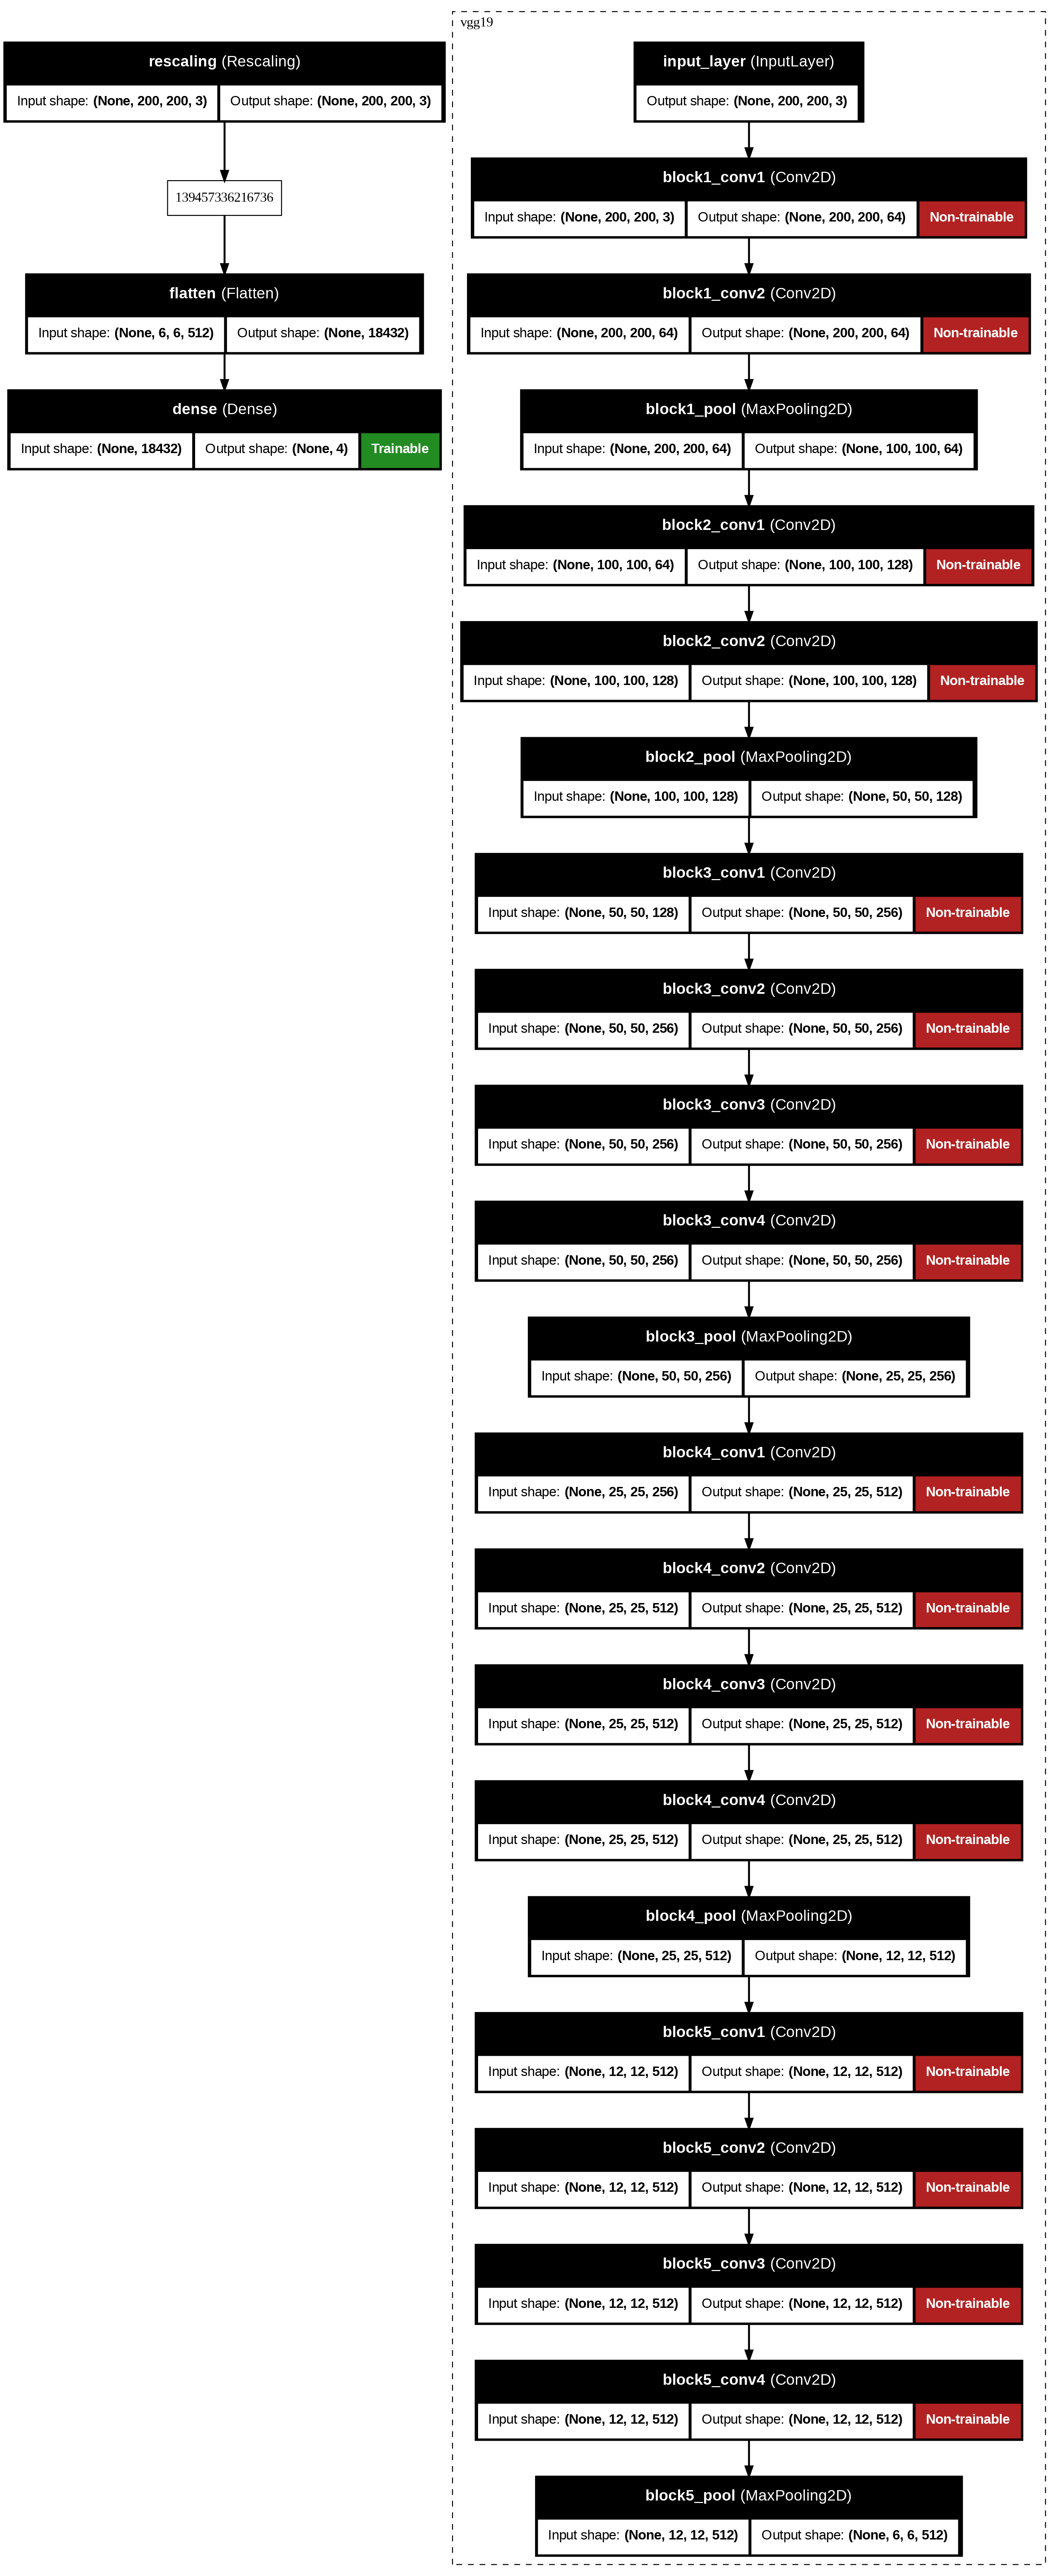

In [ ]:
# we display the shape of the model
plot_model(
    model_octai,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    show_trainable=True,
)

In [ ]:
# roc_disp = RocCurveDisplay.from_predictions(predicted_classes, true_classes)

In [ ]:
"""fig, ax = plt.subplots(figsize=(10, 10))
target_names = iris_data.target_names
colors = cycle(test_ds.class_names)
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        test_y[:, class_id],
        prob_test_vec[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )"""

'fig, ax = plt.subplots(figsize=(10, 10))\ntarget_names = iris_data.target_names\ncolors = cycle(test_ds.class_names)\nfor class_id, color in zip(range(n_classes), colors):\n    RocCurveDisplay.from_predictions(\n        test_y[:, class_id],\n        prob_test_vec[:, class_id],\n        name=f"ROC curve for {target_names[class_id]}",\n        color=color,\n        ax=ax,\n    )'

In [ ]:
# we create our custom octai_model_binary models

model_octai_binary_normal_cnv = Sequential(
    [
        Input((IMG_SIZE, IMG_SIZE, 3)),
        Rescaling(1.0 / 255.0),
        model_vgg19,
        Flatten(),
        Dense(1, activation="sigmoid"),
    ]
)

model_octai_binary_normal_drusen = Sequential(
    [
        Input((IMG_SIZE, IMG_SIZE, 3)),
        Rescaling(1.0 / 255.0),
        model_vgg19,
        Flatten(),
        Dense(1, activation="sigmoid"),
    ]
)


model_octai_binary_normal_dme = Sequential(
    [
        Input((IMG_SIZE, IMG_SIZE, 3)),
        Rescaling(1.0 / 255.0),
        model_vgg19,
        Flatten(),
        Dense(1, activation="sigmoid"),
    ]
)

In [ ]:
# we save the log training of our binary model

csv_logger_callback_binary_normal_cnv = CSVLogger(
    f"../{octai_model_version}_training_logger_binary_normal_cnv.log",
    separator=",",
    append=False,
)
csv_logger_callback_binary_normal_drusen = CSVLogger(
    f"../{octai_model_version}_training_logger_binary_normal_drusen.log",
    separator=",",
    append=False,
)
csv_logger_callback_binary_normal_dme = CSVLogger(
    f"../{octai_model_version}_training_logger_binary_normal_dme.log",
    separator=",",
    append=False,
)

In [ ]:
# we definie our EarlyStopping function to trigger during the training of our binary models
early_stopping_binary = EarlyStopping(
    monitor="val_loss", verbose=1, patience=3, restore_best_weights=True
)

In [ ]:
"""we define a list of metrics we would like to keep track off during the training and be analysed further to asses our
biniary model strenght"""

model_metrics_binary = [
    BinaryAccuracy(),
    TruePositives(),
    TrueNegatives(),
    FalsePositives(),
    FalseNegatives(),
    AUC(),
    Precision(),
    Recall(),
    PrecisionAtRecall(0.5),
    RecallAtPrecision(0.5),
    SensitivityAtSpecificity(0.5),
    SpecificityAtSensitivity(0.5),
    MeanAbsoluteError(),
    R2Score(),
    RootMeanSquaredError(),
]

In [ ]:
# we compile the model and build our binary models
model_octai_binary_normal_cnv.compile(
    loss=BinaryCrossentropy(), optimizer=Adam(), metrics=model_metrics_binary
)
model_octai_binary_normal_drusen.compile(
    loss=BinaryCrossentropy(), optimizer=Adam(), metrics=model_metrics_binary
)
model_octai_binary_normal_dme.compile(
    loss=BinaryCrossentropy(), optimizer=Adam(), metrics=model_metrics_binary
)

model_octai_binary_normal_cnv.build()
model_octai_binary_normal_drusen.build()
model_octai_binary_normal_drusen.build()

model_octai_binary_normal_cnv.summary()
model_octai_binary_normal_drusen.summary()
model_octai_binary_normal_dme.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 6, 6, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          18,433 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,042,817 (76.46 MB)

 Trainable params: 18,433 (72.00 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 6, 6, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │          18,433 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,042,817 (76.46 MB)

 Trainable params: 18,433 (72.00 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 6, 6, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │          18,433 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,042,817 (76.46 MB)

 Trainable params: 18,433 (72.00 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
# we load our training data via a generator to feed our our model
train_ds_binary_normal_cnv = keras.utils.image_dataset_from_directory(
    directory=train_dir,
    batch_size=TRAIN_BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    class_names=CLASSES_NORMAL_CNV,
)

train_ds_binary_normal_drusen = keras.utils.image_dataset_from_directory(
    directory=train_dir,
    batch_size=TRAIN_BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    class_names=CLASSES_NORMAL_DRUSEN,
)

train_ds_binary_normal_dme = keras.utils.image_dataset_from_directory(
    directory=train_dir,
    batch_size=TRAIN_BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    class_names=CLASSES_NORMAL_DME,
)

Found 62191 files belonging to 2 classes.
Found 42179 files belonging to 2 classes.
Found 44091 files belonging to 2 classes.


In [ ]:
# we load our validation data via a generator to feed our our model
val_ds_binary_normal_cnv = keras.utils.image_dataset_from_directory(
    directory=val_dir,
    batch_size=VALIDATION_BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    class_names=CLASSES_NORMAL_CNV,
)

val_ds_binary_normal_drusen = keras.utils.image_dataset_from_directory(
    directory=val_dir,
    batch_size=VALIDATION_BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    class_names=CLASSES_NORMAL_DRUSEN,
)

val_ds_binary_normal_dme = keras.utils.image_dataset_from_directory(
    directory=val_dir,
    batch_size=VALIDATION_BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    class_names=CLASSES_NORMAL_DME,
)

Found 17768 files belonging to 2 classes.
Found 12050 files belonging to 2 classes.
Found 12597 files belonging to 2 classes.


In [ ]:
# we definie the weights of each class in a variable to be given to the model
_class_number_binary_normal_cnv = {0: "NORMAL", 1: "CNV"}
_class_weight_model_binary_normal_cnv = {
    k: weigth_binary_normal_cnv[v] for k, v in _class_number_binary_normal_cnv.items()
}

_class_number_binary_normal_drusen = {0: "NORMAL", 1: "DRUSEN"}
_class_weight_model_binary_normal_drusen = {
    k: weigth_binary_normal_drusen[v]
    for k, v in _class_number_binary_normal_drusen.items()
}

_class_number_binary_normal_dme = {0: "NORMAL", 1: "DME"}
_class_weight_model_binary_normal_dme = {
    k: weigth_binary_normal_dme[v] for k, v in _class_number_binary_normal_dme.items()
}

In [ ]:
# we use keras functionality to optmise the memory and GPU during the feed of the data
train_ds_binary_normal_cnv = train_ds_binary_normal_cnv.prefetch(buffer_size=AUTOTUNE)
train_ds_binary_normal_drusen = train_ds_binary_normal_drusen.prefetch(
    buffer_size=AUTOTUNE
)
train_ds_binary_normal_dme = train_ds_binary_normal_dme.prefetch(buffer_size=AUTOTUNE)

val_ds_binary_normal_cnv = val_ds_binary_normal_cnv.prefetch(buffer_size=AUTOTUNE)
val_ds_binary_normal_drusen = val_ds_binary_normal_drusen.prefetch(buffer_size=AUTOTUNE)
val_ds_binary_normal_dme = val_ds_binary_normal_dme.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# we train our binary model normal and cnv
history_vgg_binary_normal_cnv = model_octai_binary_normal_cnv.fit(
    train_ds_binary_normal_cnv,
    epochs=5, #fix put 10
    validation_data=val_ds_binary_normal_cnv,
    callbacks=[early_stopping_binary, csv_logger_callback],
    class_weight=_class_weight_model_binary_normal_cnv,
    validation_batch_size=VALIDATION_BATCH_SIZE,
)

Epoch 1/5
3887/3887 ━━━━━━━━━━━━━━━━━━━━ 479s 120ms/step - auc_1: 0.9917 - binary_accuracy: 0.9677 - false_negatives_1: 461.6628 - false_positives_1: 225.5234 - loss: 0.0434 - mean_absolute_error: 0.0573 - precision_1: 0.9728 - precision_at_recall_1: 0.9959 - r2_score: 0.8979 - recall_1: 0.9503 - recall_at_precision_1: 0.9972 - root_mean_squared_error: 0.1506 - sensitivity_at_specificity_1: 0.9965 - specificity_at_sensitivity_1: 0.9975 - true_negatives_1: 17771.5410 - true_positives_1: 12653.2676 - val_auc_1: 0.9986 - val_binary_accuracy: 0.9923 - val_false_negatives_1: 69.0000 - val_false_positives_1: 67.0000 - val_loss: 0.0276 - val_mean_absolute_error: 0.0128 - val_precision_1: 0.9911 - val_precision_at_recall_1: 0.9991 - val_r2_score: 0.9729 - val_recall_1: 0.9908 - val_recall_at_precision_1: 0.9987 - val_root_mean_squared_error: 0.0813 - val_sensitivity_at_specificity_1: 0.9987 - val_specificity_at_sensitivity_1: 0.9994 - val_true_negatives_1: 10210.0000 - val_true_positives_1: 74

In [ ]:
# we save our trained model
model_octai_binary_normal_cnv.save(f"{octai_model_version}_binary_normal_cnv_.keras")

# serialize model to JSON
model_json = model_octai_binary_normal_cnv.to_json()
with open(file=f"{octai_model_version}_binary_normal_cnv.json", mode="w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model_octai_binary_normal_cnv.save_weights(
    f"{octai_model_version}_binary_normal_cnv.weights.h5"
)

In [ ]:
# we define the metrics we chose to display for our binary models
display_metrics = [
    m for m in history_vgg_binary_normal_cnv.history.keys() if "val_" not in m
]
display_metrics = [m for m in display_metrics if "f1_" not in m]

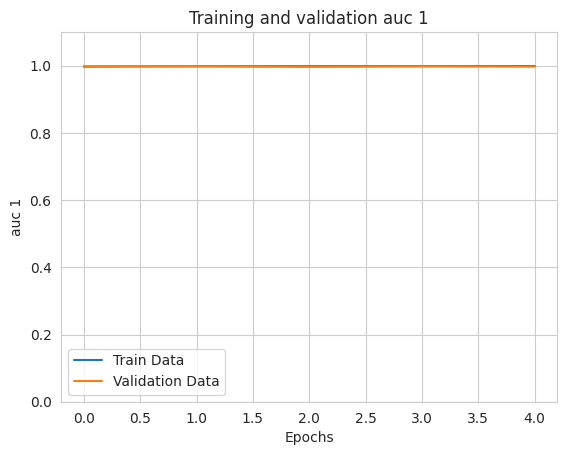

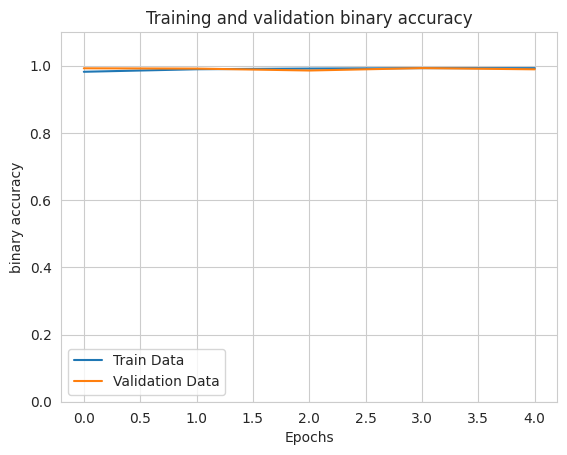

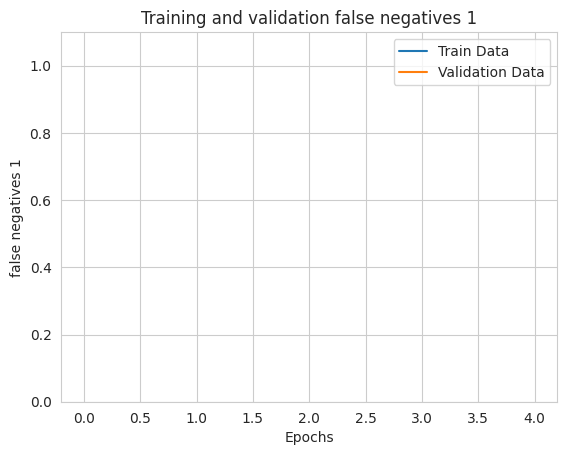

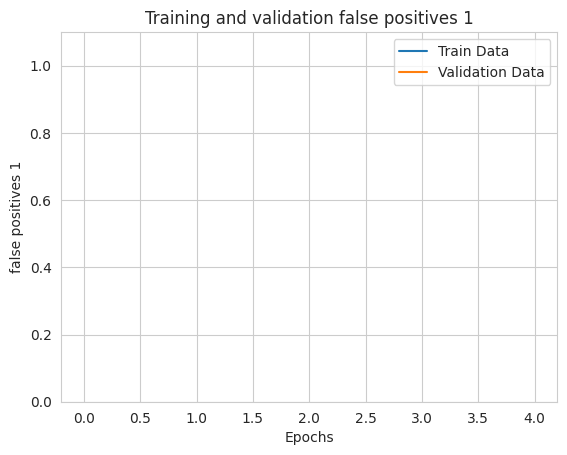

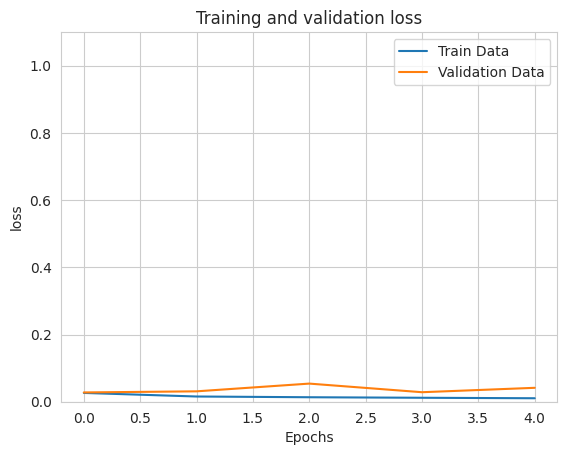

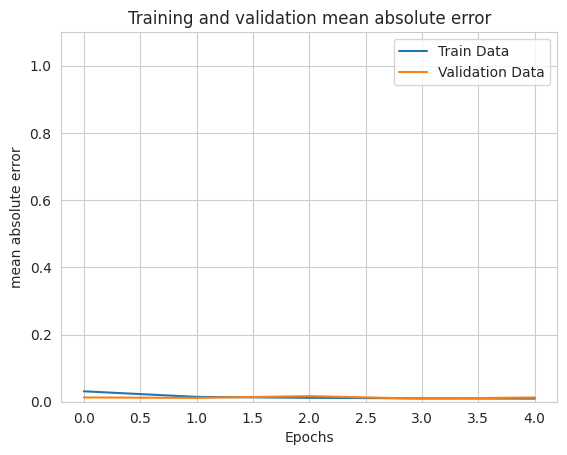

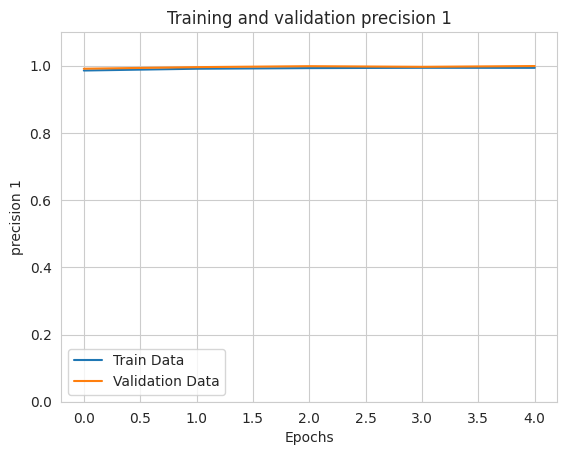

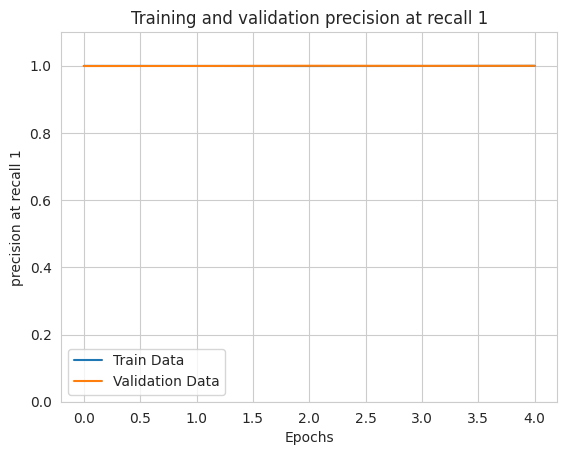

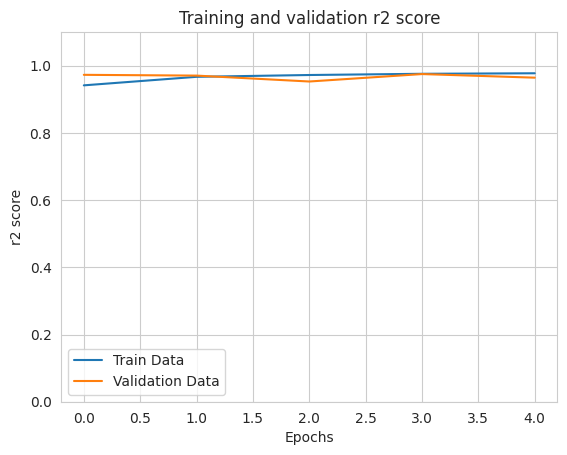

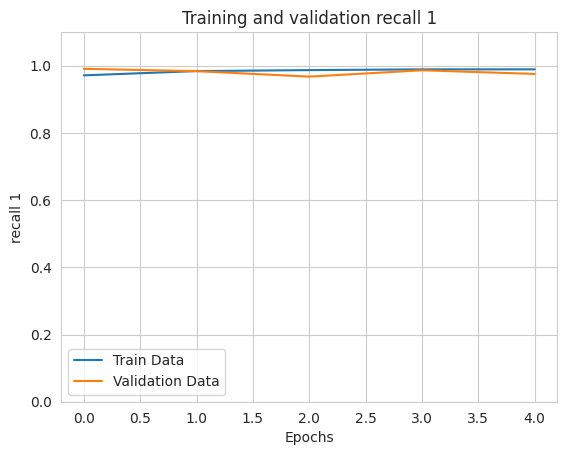

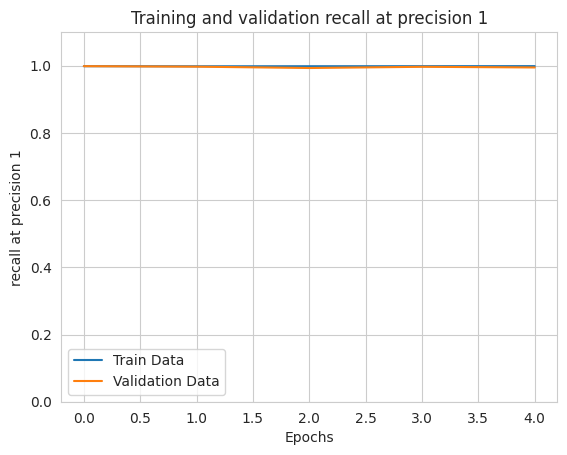

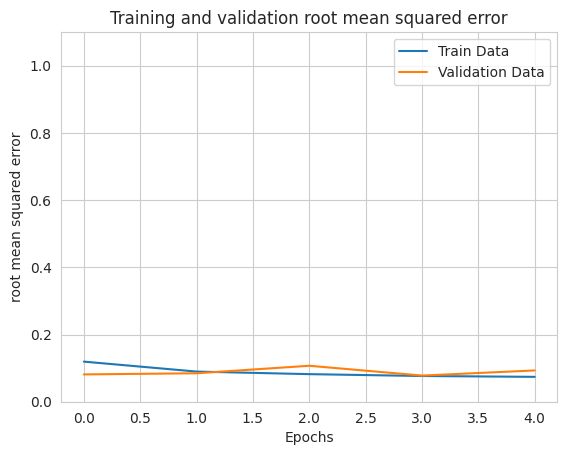

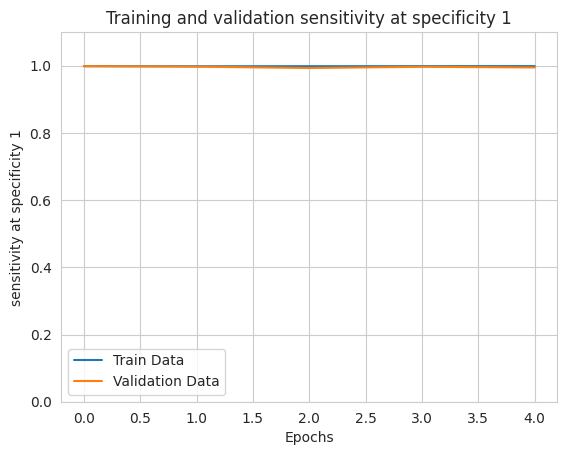

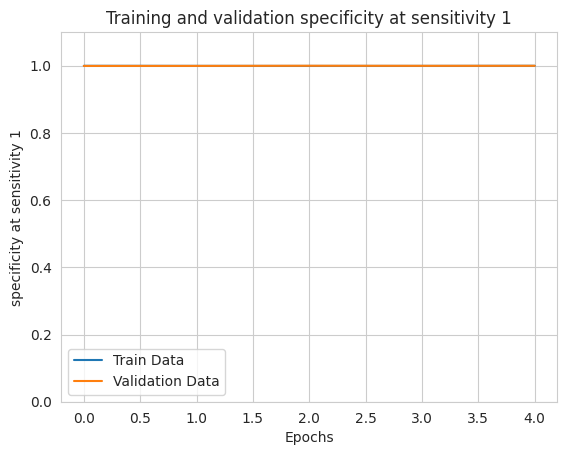

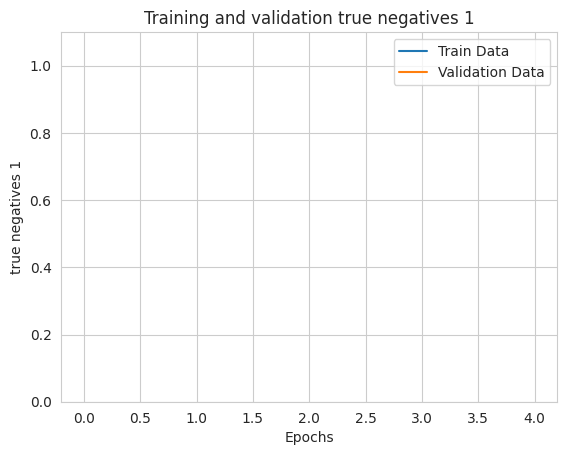

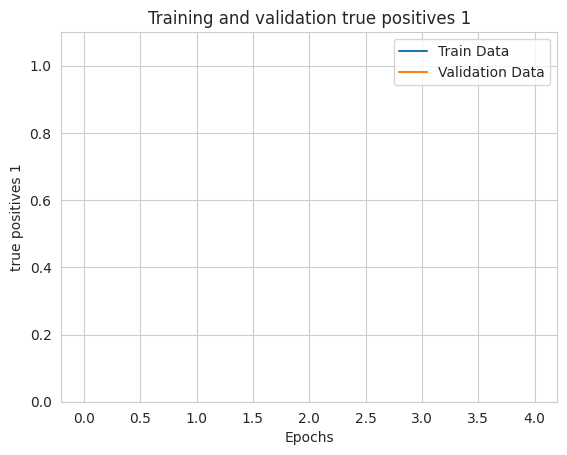

In [ ]:
plt.rcParams["axes.grid"] = True
for (
    train_metric_name,
    train_metric_value,
) in history_vgg_binary_normal_cnv.history.items():
    if train_metric_name in display_metrics:
        val_metric_name = "val_" + train_metric_name

        train_metric_data = dict(
            zip(
                range(len(history_vgg_binary_normal_cnv.history[train_metric_name])),
                history_vgg_binary_normal_cnv.history[train_metric_name],
            )
        )
        val_metric_data = dict(
            zip(
                range(len(history_vgg_binary_normal_cnv.history[val_metric_name])),
                history_vgg_binary_normal_cnv.history[val_metric_name],
            )
        )
        sns.lineplot(
            data=train_metric_data,
            x=train_metric_data.keys(),
            y=train_metric_data.values(),
            label="Train Data",
        )
        sns.lineplot(
            data=val_metric_data,
            x=val_metric_data.keys(),
            y=val_metric_data.values(),
            label="Validation Data",
        )
        ax = plt.gca()  # we could display zoomed and non zoomed graphs
        ax.set_ylim(bottom=[0, 1.1])
        plt.xlabel(xlabel="Epochs")
        metric = train_metric_name.replace("_", " ")
        plt.ylabel(ylabel=metric)
        plt.title(label=f"Training and validation {metric}")
        plt.legend()
        plt.show()
        print("")

In [ ]:
test_ds_binary_normal_cnv = keras.utils.image_dataset_from_directory(
    directory=test_dir,
    batch_size=VALIDATION_BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    class_names=CLASSES_NORMAL_CNV,
    shuffle=False,
)

test_ds_binary_normal_drusen = keras.utils.image_dataset_from_directory(
    directory=test_dir,
    batch_size=VALIDATION_BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    class_names=CLASSES_NORMAL_DRUSEN,
    shuffle=False,
)

test_ds_binary_normal_dme = keras.utils.image_dataset_from_directory(
    directory=test_dir,
    batch_size=VALIDATION_BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    class_names=CLASSES_NORMAL_DME,
    shuffle=False,
)

Found 8886 files belonging to 2 classes.
Found 6027 files belonging to 2 classes.
Found 6300 files belonging to 2 classes.


In [ ]:
# we evaluate our trained model with our test data
baseline_results_binary_normal_cnv = model_octai_binary_normal_cnv.evaluate(
    test_ds_binary_normal_cnv
)

556/556 ━━━━━━━━━━━━━━━━━━━━ 63s 112ms/step - auc_1: 0.4231 - binary_accuracy: 0.9872 - false_negatives_1: 10.3124 - false_positives_1: 46.4111 - loss: 0.0326 - mean_absolute_error: 0.0163 - precision_1: 0.3949 - precision_at_recall_1: 0.4208 - r2_score: 0.3835 - recall_1: 0.4188 - recall_at_precision_1: 0.4233 - root_mean_squared_error: 0.0932 - sensitivity_at_specificity_1: 0.4233 - specificity_at_sensitivity_1: 0.4234 - true_negatives_1: 3615.9514 - true_positives_1: 791.2603


In [ ]:
for name, value in zip(
    ["loss"] + [metric.name for metric in model_metrics_binary],
    baseline_results_binary_normal_cnv,
):
    print(f"{name} : {value}")


loss :  0.03264247998595238
binary_accuracy :  0.9881836771965027
true_positives_1 :  3704.0
true_negatives_1 :  5077.0
false_positives_1 :  63.0
false_negatives_1 :  42.0
auc_1 :  0.9985662698745728
precision_1 :  0.983275830745697
recall_1 :  0.9887880682945251
precision_at_recall_1 :  0.9988365173339844
recall_at_precision_1 :  0.9989321827888489
sensitivity_at_specificity_1 :  0.9989321827888489
specificity_at_sensitivity_1 :  0.9992218017578125
mean_absolute_error :  0.015216208063066006
r2_score :  0.9650751352310181
root_mean_squared_error :  0.09228401631116867


In [ ]:
# we compute predictions to compute additional metrics
predictions_binary_normal_cnv = model_octai_binary_normal_cnv.predict(test_ds_binary_normal_cnv)

556/556 ━━━━━━━━━━━━━━━━━━━━ 35s 64ms/step


In [ ]:
true_classes_binary_normal_cnv = tensorflow.concat(values=[y for _, y in test_ds_binary_normal_cnv], axis=0)
predictions_binary_normal_cnv = tensorflow.concat([item for item in predictions_binary_normal_cnv], axis = 0)
predictions_binary_normal_cnv = np.rint(predictions_binary_normal_cnv).astype(int)

In [ ]:
# we compute the confusition matrix
cm_normalized_binary_normal_cnv = confusion_matrix(
    y_true=true_classes_binary_normal_cnv, y_pred=predictions_binary_normal_cnv, normalize="true",
)
cm_binary_normal_cnv = confusion_matrix(y_true=true_classes_binary_normal_cnv, y_pred=predictions_binary_normal_cnv)

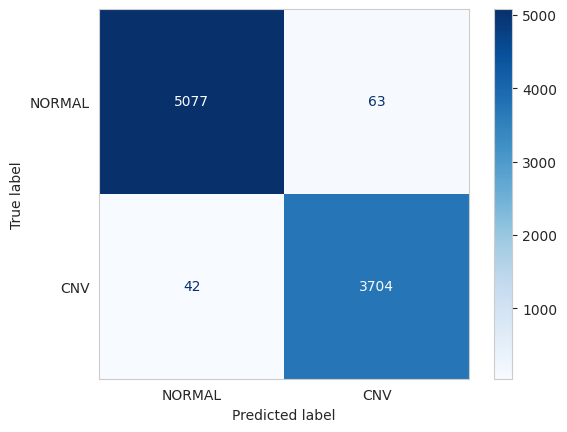

In [ ]:
# we print the confusion matrix
plt.rcParams["axes.grid"] = False
disp = ConfusionMatrixDisplay(confusion_matrix=cm_binary_normal_cnv,display_labels=test_ds_binary_normal_cnv.class_names)
disp = disp.plot(cmap=plt.cm.Blues)
plt.show()

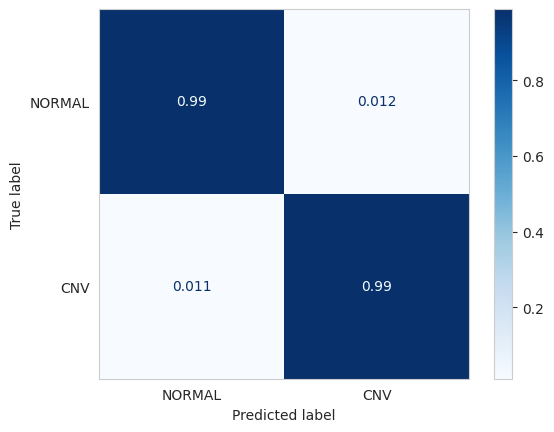

In [ ]:
# we print the confusion matrix normalised
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_normalized_binary_normal_cnv, display_labels=test_ds_binary_normal_cnv.class_names
)
disp = disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
# we compute the cohen_kapp score
cohen_kappa = cohen_kappa_score(y1=true_classes_binary_normal_cnv, y2=predictions_binary_normal_cnv)
cohen_kappa

0.9757894475173876

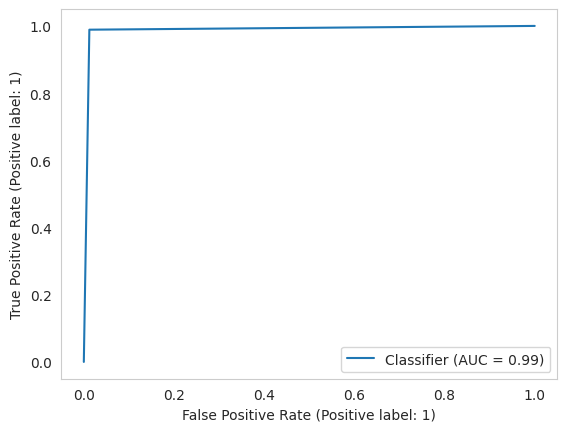

In [ ]:

RocCurveDisplay.from_predictions(true_classes_binary_normal_cnv, predictions_binary_normal_cnv)

In [ ]:
# we compute the cohen_kapp score
cohen_kappa_binary_normal_cnv = cohen_kappa_score(y1=true_classes_binary_normal_cnv, y2=predictions_binary_normal_cnv)
print(f"cohen_kappa : {cohen_kappa_binary_normal_cnv}")

for metric_idx, metric in enumerate(model_metrics_binary):
  if isinstance(metric,TruePositives):
    tp = baseline_results_binary_normal_cnv[metric_idx+1]
  if isinstance(metric,TrueNegatives):
    tn = baseline_results_binary_normal_cnv[metric_idx+1]
  if isinstance(metric,FalsePositives):
    fp = baseline_results_binary_normal_cnv[metric_idx+1]
  if isinstance(metric,FalseNegatives):
    fn = baseline_results_binary_normal_cnv[metric_idx+1]

_sensibility = tp/(tp+fn)
_specificity = tn/(tn+fp)

print(f"TruePositives : {tp}")
print(f"TrueNegatives : {tn}")
print(f"FalsePositives : {fp}")
print(f"FalseNegatives : {fn}")
print(f"Sensibility : {_sensibility:.2%}")
print(f"Specificity : {_specificity:.2%}")
print(f"VPP : {tp/(tp+fp):.2%}")
print(f"VPN : {tn/(tn+fn):.2%}")
print(f"RVP : {_sensibility/(1-_specificity)}")
print(f"RVP : {(1-_sensibility)/(_specificity)}")



TruePositives : 3704.0
TrueNegatives : 5077.0
FalsePositives : 63.0
FalseNegatives : 42.0
Sensibility : 98.88%
Specificity : 98.77%
VPP : 98.33%
VPN : 99.18%
RVP : 80.67254807244159
RVP : 0.011351087539137


In [ ]:
# we train our binary model normal and drusen
history_vgg_binary_normal_drusen = model_octai_binary_normal_drusen.fit(
    train_ds_binary_normal_drusen,
    epochs=5, #fix put 10
    validation_data=val_ds_binary_normal_drusen,
    callbacks=[early_stopping_binary, csv_logger_callback],
    class_weight=_class_weight_model_binary_normal_drusen,
    validation_batch_size=VALIDATION_BATCH_SIZE,
)

Epoch 1/5
2637/2637 ━━━━━━━━━━━━━━━━━━━━ 288s 107ms/step - auc_1: 0.9694 - binary_accuracy: 0.9474 - false_negatives_1: 1511.8032 - false_positives_1: 108.1221 - loss: 0.0557 - mean_absolute_error: 0.0594 - precision_1: 0.9803 - precision_at_recall_1: 0.9985 - r2_score: 0.7655 - recall_1: 0.7925 - recall_at_precision_1: 0.9609 - root_mean_squared_error: 0.2043 - sensitivity_at_specificity_1: 0.9706 - specificity_at_sensitivity_1: 0.9997 - true_negatives_1: 23031.2598 - true_positives_1: 5346.7998 - val_auc_1: 0.9422 - val_binary_accuracy: 0.9455 - val_false_negatives_1: 649.0000 - val_false_positives_1: 8.0000 - val_loss: 0.2179 - val_mean_absolute_error: 0.0565 - val_precision_1: 0.9929 - val_precision_at_recall_1: 0.9961 - val_r2_score: 0.6299 - val_recall_1: 0.6340 - val_recall_at_precision_1: 0.8945 - val_root_mean_squared_error: 0.2155 - val_sensitivity_at_specificity_1: 0.8945 - val_specificity_at_sensitivity_1: 0.9996 - val_true_negatives_1: 10269.0000 - val_true_positives_1: 11

In [ ]:
# we save our trained model
model_octai_binary_normal_drusen.save(f"{octai_model_version}_binary_normal_drusen_.keras")

# serialize model to JSON
model_json = model_octai_binary_normal_drusen.to_json()
with open(file=f"{octai_model_version}_binary_normal_drusen.json", mode="w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model_octai_binary_normal_drusen.save_weights(
    f"{octai_model_version}_binary_normal_drusen.weights.h5"
)

In [ ]:
# we define the metrics we chose to display for our binary models
display_metrics = [
    m for m in history_vgg_binary_normal_drusen.history.keys() if "val_" not in m
]
display_metrics = [m for m in display_metrics if "f1_" not in m]

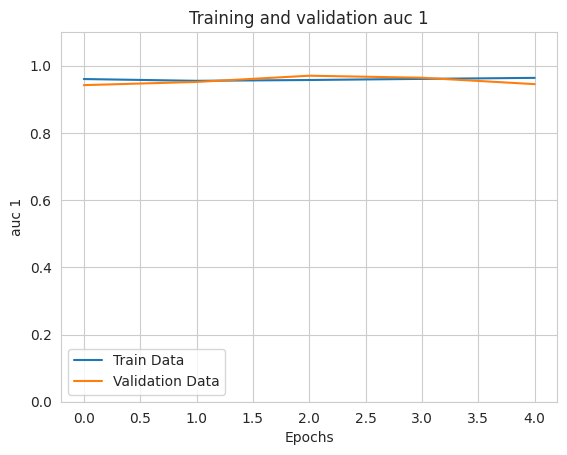

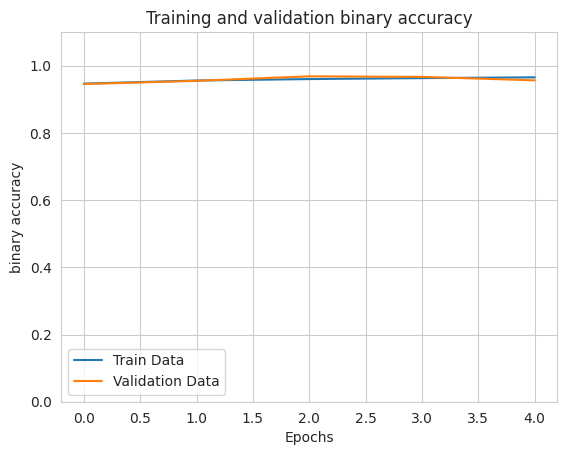

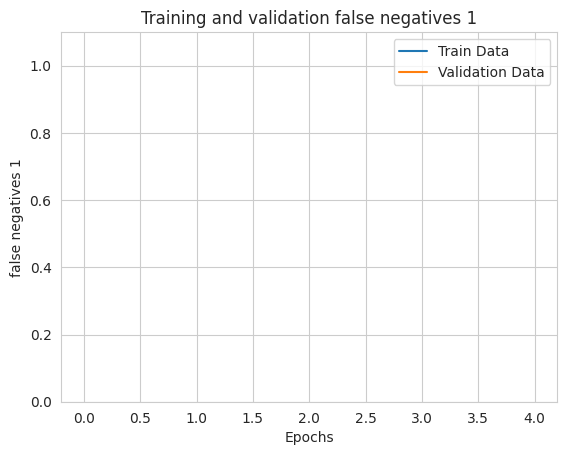

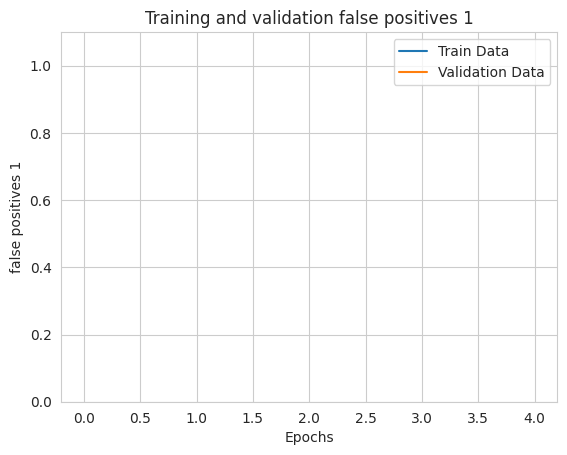

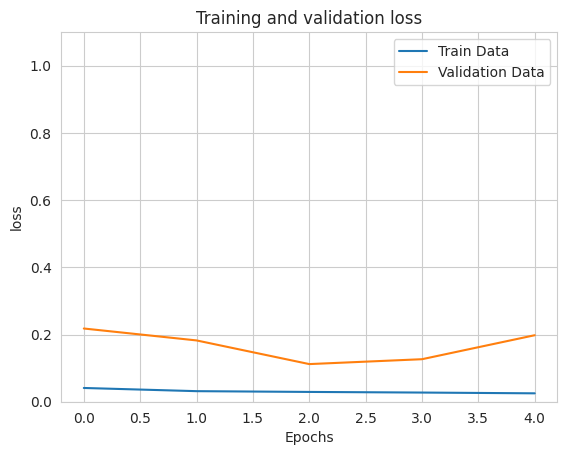

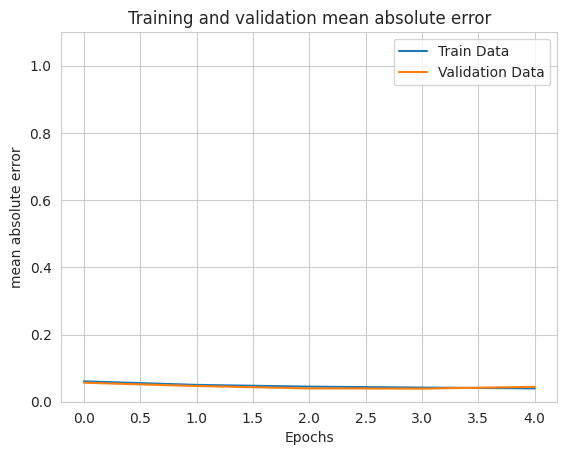

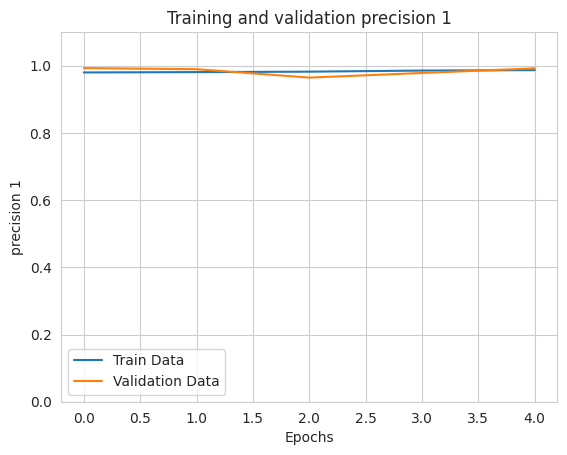

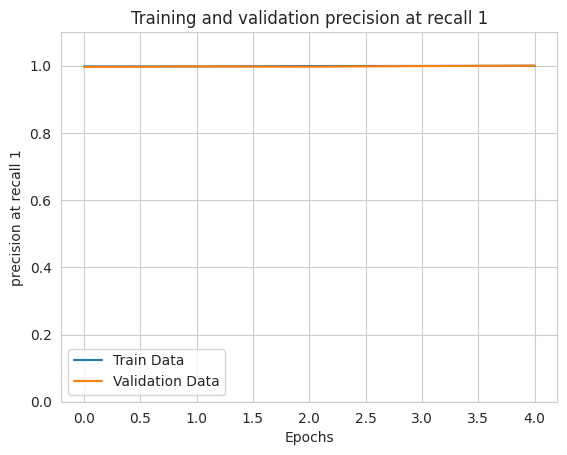

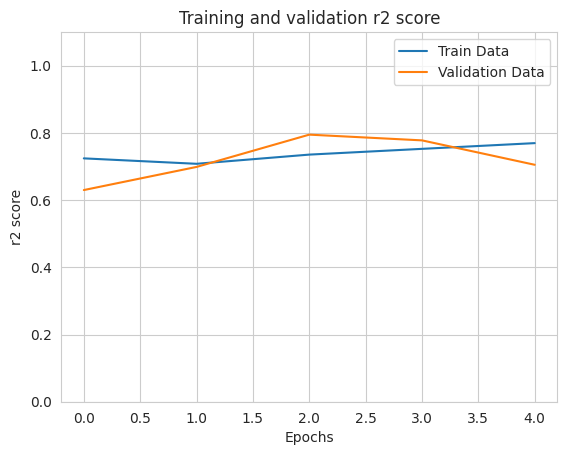

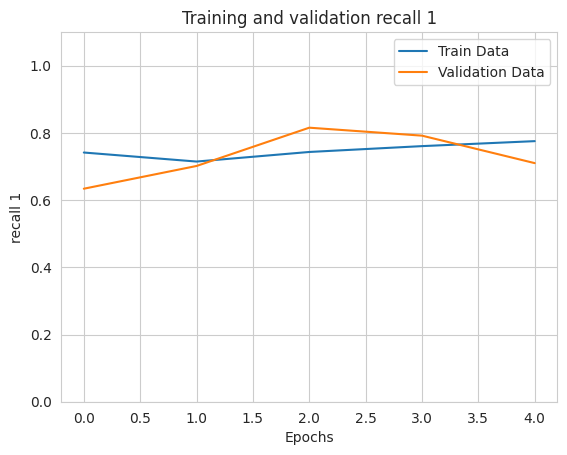

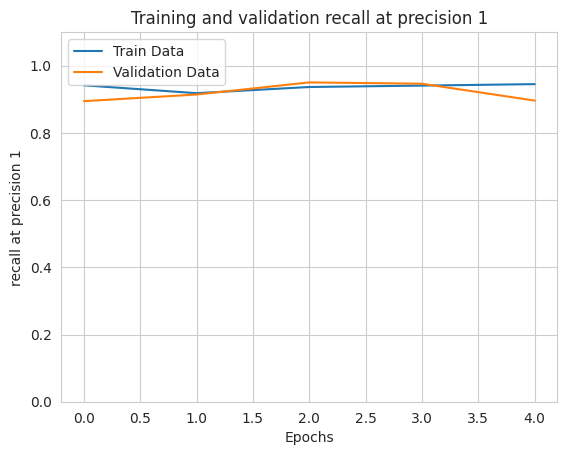

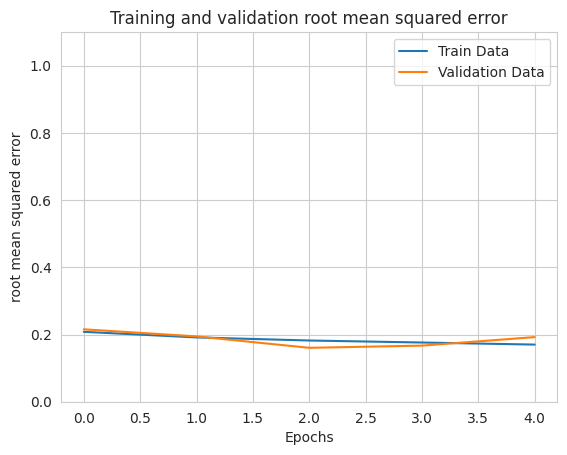

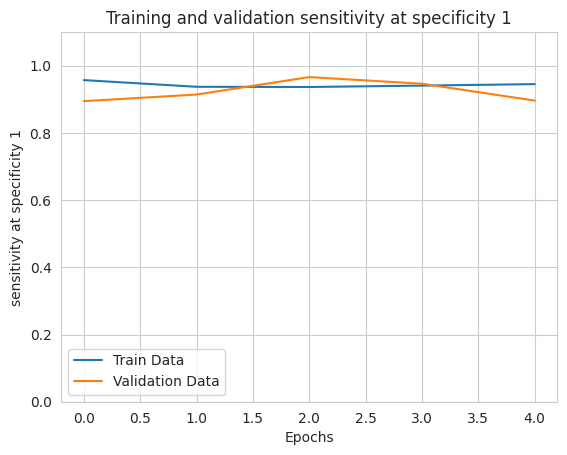

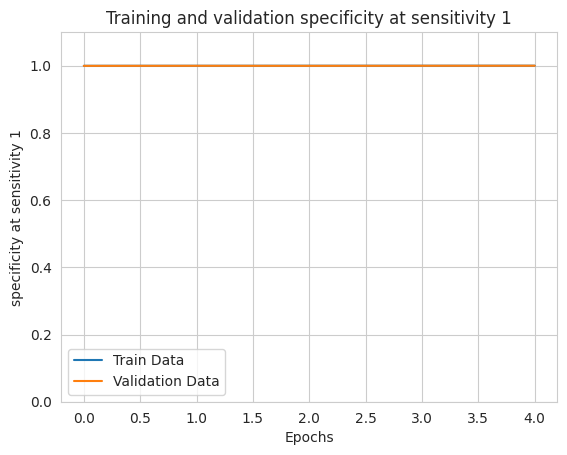

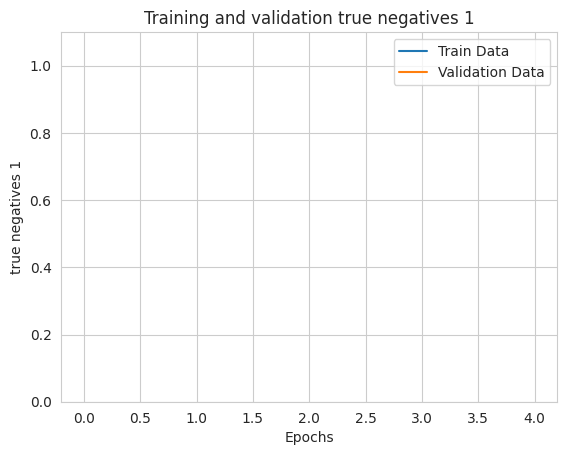

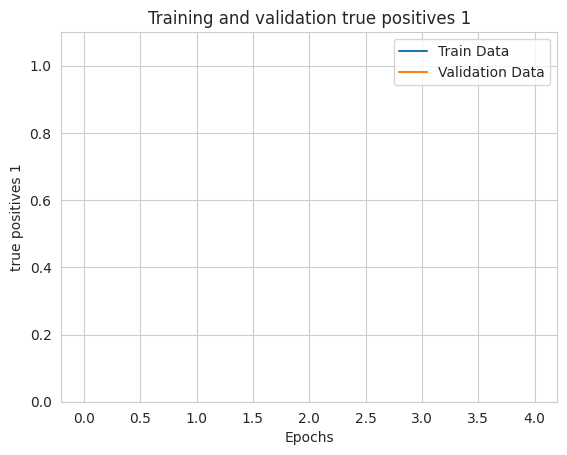

In [ ]:
plt.rcParams["axes.grid"] = True
for (
    train_metric_name,
    train_metric_value,
) in history_vgg_binary_normal_drusen.history.items():
    if train_metric_name in display_metrics:
        val_metric_name = "val_" + train_metric_name

        train_metric_data = dict(
            zip(
                range(len(history_vgg_binary_normal_drusen.history[train_metric_name])),
                history_vgg_binary_normal_drusen.history[train_metric_name],
            )
        )
        val_metric_data = dict(
            zip(
                range(len(history_vgg_binary_normal_drusen.history[val_metric_name])),
                history_vgg_binary_normal_drusen.history[val_metric_name],
            )
        )
        sns.lineplot(
            data=train_metric_data,
            x=train_metric_data.keys(),
            y=train_metric_data.values(),
            label="Train Data",
        )
        sns.lineplot(
            data=val_metric_data,
            x=val_metric_data.keys(),
            y=val_metric_data.values(),
            label="Validation Data",
        )
        ax = plt.gca()  # we could display zoomed and non zoomed graphs
        ax.set_ylim(bottom=[0, 1.1])
        plt.xlabel(xlabel="Epochs")
        metric = train_metric_name.replace("_", " ")
        plt.ylabel(ylabel=metric)
        plt.title(label=f"Training and validation {metric}")
        plt.legend()
        plt.show()
        print("")

In [ ]:
# we evaluate our trained model with our test data
baseline_results_binary_normal_drusen = model_octai_binary_normal_drusen.evaluate(
    test_ds_binary_normal_drusen
)

377/377 ━━━━━━━━━━━━━━━━━━━━ 57s 151ms/step - auc_1: 0.1416 - binary_accuracy: 0.9948 - false_negatives_1: 28.2460 - false_positives_1: 1.1402 - loss: 0.0225 - mean_absolute_error: 0.0073 - precision_1: 0.1473 - precision_at_recall_1: 0.1443 - r2_score: 0.0864 - recall_1: 0.0835 - recall_at_precision_1: 0.1292 - root_mean_squared_error: 0.0429 - sensitivity_at_specificity_1: 0.1343 - specificity_at_sensitivity_1: 0.1507 - true_negatives_1: 2961.4946 - true_positives_1: 41.0503


In [ ]:
for name, value in zip(
    ["loss"] + [metric.name for metric in model_metrics_binary],
    baseline_results_binary_normal_drusen,
):
    print(f"{name} : {value}")


loss : 0.20636631548404694
binary_accuracy : 0.9455782175064087
true_positives_1 : 561.0
true_negatives_1 : 5138.0
false_positives_1 : 2.0
false_negatives_1 : 326.0
auc_1 : 0.95084547996521
precision_1 : 0.9964476227760315
recall_1 : 0.6324689984321594
precision_at_recall_1 : 0.9978355169296265
recall_at_precision_1 : 0.9120631217956543
sensitivity_at_specificity_1 : 0.9120631217956543
specificity_at_sensitivity_1 : 0.9998054504394531
mean_absolute_error : 0.056072402745485306
r2_score : 0.6403549909591675
root_mean_squared_error : 0.2124609798192978


In [ ]:
# we compute predictions to compute additional metrics
predictions_binary_normal_drusen = model_octai_binary_normal_drusen.predict(test_ds_binary_normal_drusen)

377/377 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step


In [ ]:
true_classes_binary_normal_drusen = tensorflow.concat(values=[y for _, y in test_ds_binary_normal_drusen], axis=0)
predictions_binary_normal_drusen = tensorflow.concat([item for item in predictions_binary_normal_drusen], axis = 0)
predictions_binary_normal_drusen = np.rint(predictions_binary_normal_drusen).astype(int)

In [ ]:
# we compute the confusition matrix
cm_normalized_binary_normal_drusen = confusion_matrix(
    y_true=true_classes_binary_normal_drusen, y_pred=predictions_binary_normal_drusen, normalize="true",
)
cm_binary_normal_drusen = confusion_matrix(y_true=true_classes_binary_normal_drusen, y_pred=predictions_binary_normal_drusen)

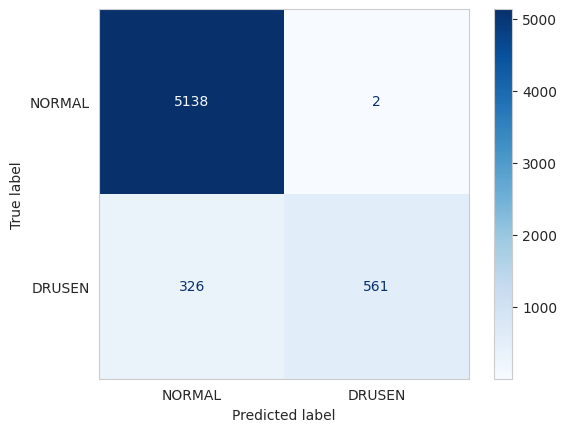

In [ ]:
# we print the confusion matrix
plt.rcParams["axes.grid"] = False
disp = ConfusionMatrixDisplay(confusion_matrix=cm_binary_normal_drusen,display_labels=test_ds_binary_normal_drusen.class_names)
disp = disp.plot(cmap=plt.cm.Blues)
plt.show()

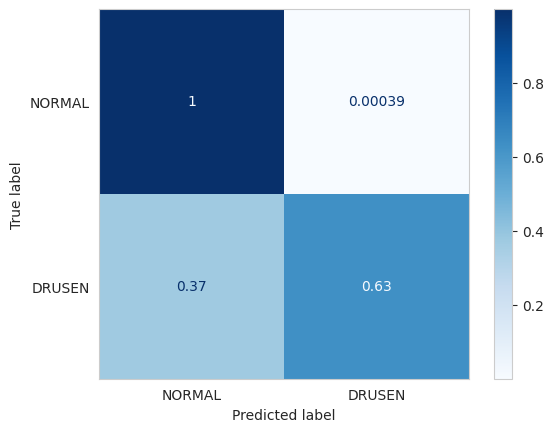

In [ ]:
# we print the confusion matrix normalised
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_normalized_binary_normal_drusen, display_labels=test_ds_binary_normal_drusen.class_names
)
disp = disp.plot(cmap=plt.cm.Blues)
plt.show()

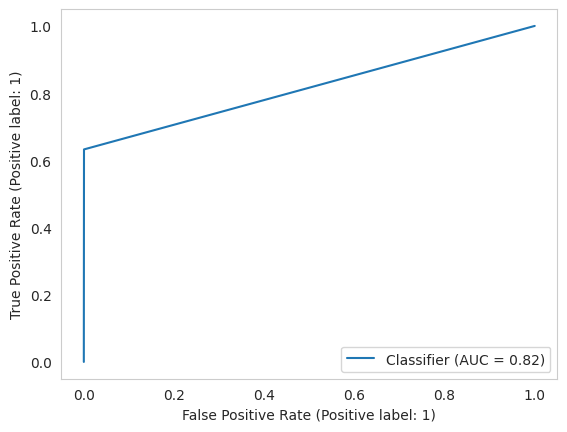

In [ ]:
RocCurveDisplay.from_predictions(true_classes_binary_normal_drusen, predictions_binary_normal_drusen)

In [ ]:
# we compute the cohen_kapp score
cohen_kappa_binary_normal_drusen = cohen_kappa_score(y1=true_classes_binary_normal_drusen, y2=predictions_binary_normal_drusen)

#we diplay various metrics
for metric_idx, metric in enumerate(model_metrics_binary):
  if isinstance(metric,TruePositives):
    tp = baseline_results_binary_normal_drusen[metric_idx+1]
  if isinstance(metric,TrueNegatives):
    tn = baseline_results_binary_normal_drusen[metric_idx+1]
  if isinstance(metric,FalsePositives):
    fp = baseline_results_binary_normal_drusen[metric_idx+1]
  if isinstance(metric,FalseNegatives):
    fn = baseline_results_binary_normal_drusen[metric_idx+1]

_sensibility = tp/(tp+fn)
_specificity = tn/(tn+fp)

print(f"TruePositives : {tp}")
print(f"TrueNegatives : {tn}")
print(f"FalsePositives : {fp}")
print(f"FalseNegatives : {fn}")
print(f"Sensibility : {_sensibility:.2%}")
print(f"Specificity : {_specificity:.2%}")
print(f"VPP : {tp/(tp+fp):.2%}")
print(f"VPN : {tn/(tn+fn):.2%}")
print(f"RVP : {_sensibility/(1-_specificity)}")
print(f"RVP : {(1-_sensibility)/(_specificity)}")
print(f"cohen kappa : {cohen_kappa_binary_normal_drusen}")



TruePositives : 561.0
TrueNegatives : 5138.0
FalsePositives : 2.0
FalseNegatives : 326.0
Sensibility : 63.25%
Specificity : 99.96%
VPP : 99.64%
VPN : 94.03%
RVP : 1625.4453213077848
RVP : 0.367674067221573
cohen kappa : 0.7446050508062387


In [ ]:
# we train our binary model normal and dme
history_vgg_binary_normal_dme = model_octai_binary_normal_dme.fit(
    train_ds_binary_normal_dme,
    epochs=5, #fix put 10
    validation_data=val_ds_binary_normal_dme,
    callbacks=[early_stopping_binary, csv_logger_callback],
    class_weight=_class_weight_model_binary_normal_dme,
    validation_batch_size=VALIDATION_BATCH_SIZE,
)

Epoch 1/5
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 331s 118ms/step - auc_1: 0.9304 - binary_accuracy: 0.9082 - false_negatives_1: 2472.8191 - false_positives_1: 68.1966 - loss: 0.0770 - mean_absolute_error: 0.1019 - precision_1: 0.9742 - precision_at_recall_1: 0.9707 - r2_score: 0.4990 - recall_1: 0.4825 - recall_at_precision_1: 0.8806 - root_mean_squared_error: 0.2675 - sensitivity_at_specificity_1: 0.9480 - specificity_at_sensitivity_1: 0.9968 - true_negatives_1: 23064.5391 - true_positives_1: 2485.4355 - val_auc_1: 0.9757 - val_binary_accuracy: 0.9535 - val_false_negatives_1: 402.0000 - val_false_positives_1: 184.0000 - val_loss: 0.1302 - val_mean_absolute_error: 0.0743 - val_precision_1: 0.9125 - val_precision_at_recall_1: 0.9932 - val_r2_score: 0.7617 - val_recall_1: 0.8267 - val_recall_at_precision_1: 0.9694 - val_root_mean_squared_error: 0.1892 - val_sensitivity_at_specificity_1: 0.9888 - val_specificity_at_sensitivity_1: 0.9992 - val_true_negatives_1: 10093.0000 - val_true_positives_1: 1

In [ ]:
# we save our trained model
model_octai_binary_normal_dme.save(f"{octai_model_version}_binary_normal_dme_.keras")

# serialize model to JSON
model_json = model_octai_binary_normal_dme.to_json()
with open(file=f"{octai_model_version}_binary_normal_dme.json", mode="w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model_octai_binary_normal_dme.save_weights(
    f"{octai_model_version}_binary_normal_dme.weights.h5"
)

In [ ]:
# we define the metrics we chose to display for our binary models
display_metrics = [
    m for m in history_vgg_binary_normal_dme.history.keys() if "val_" not in m
]
display_metrics = [m for m in display_metrics if "f1_" not in m]

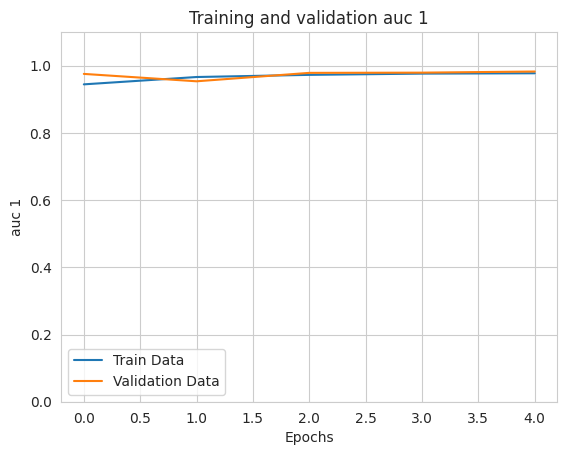

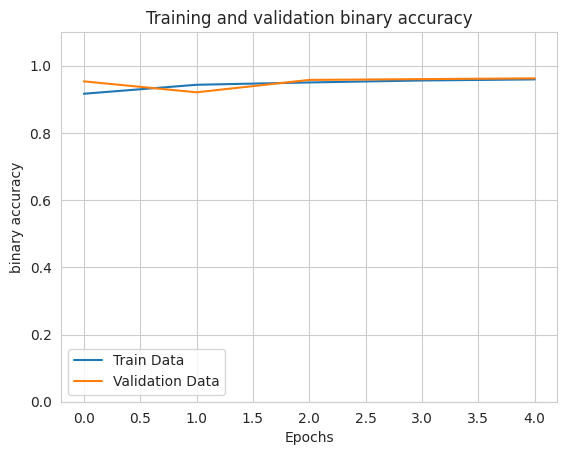

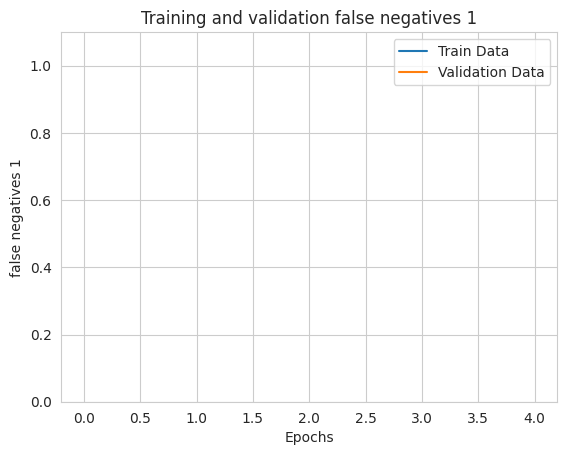

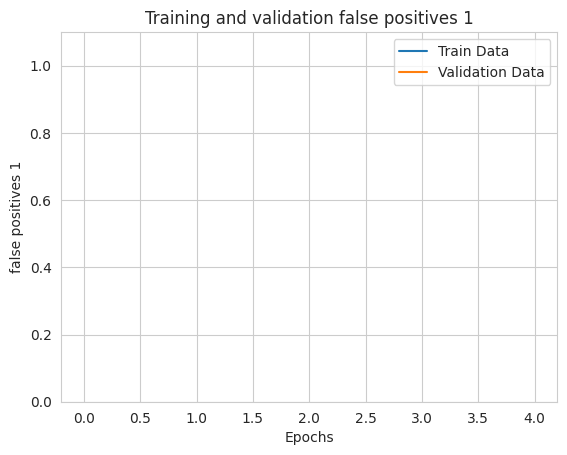

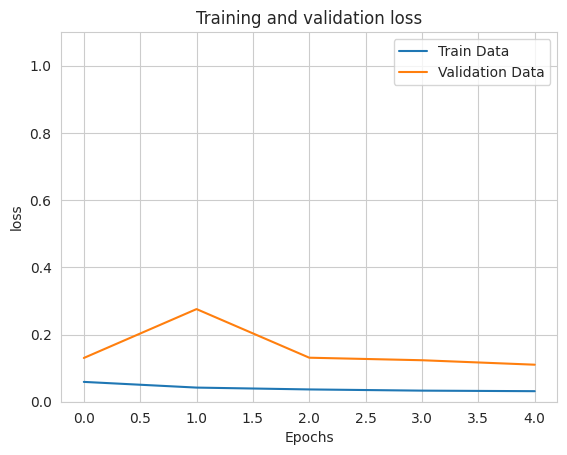

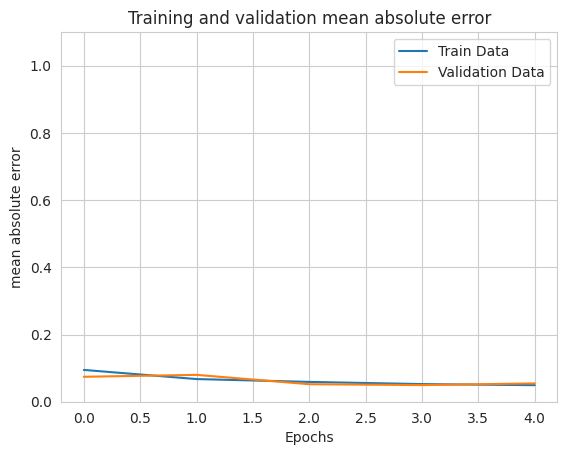

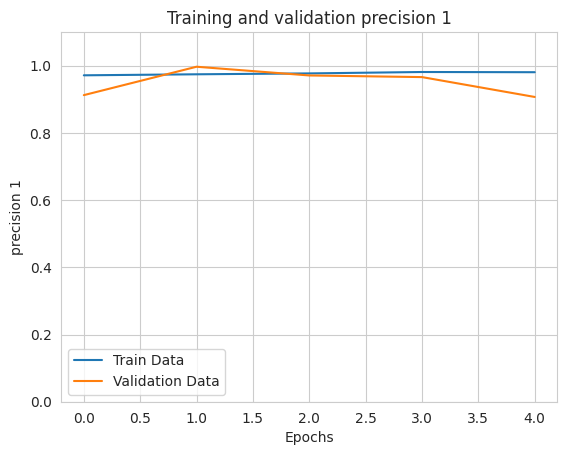

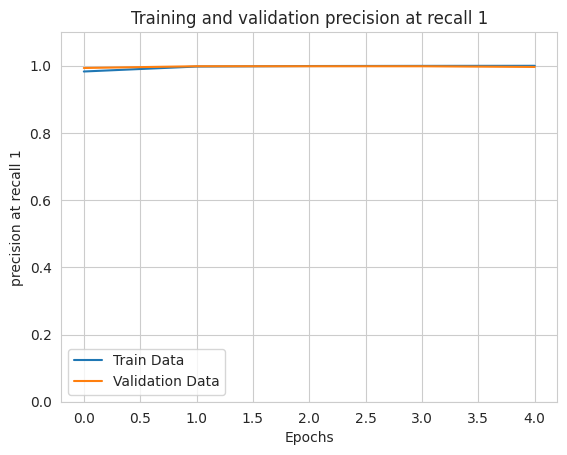

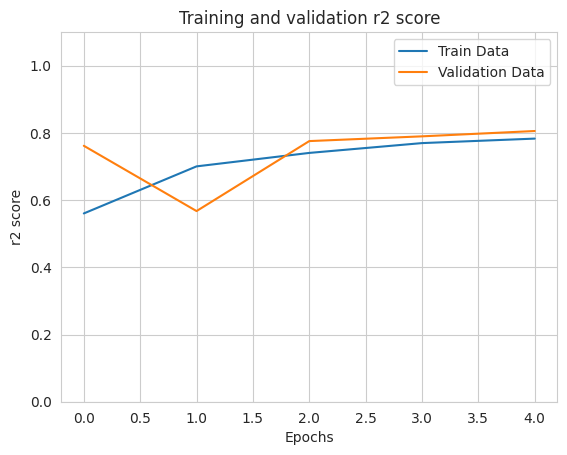

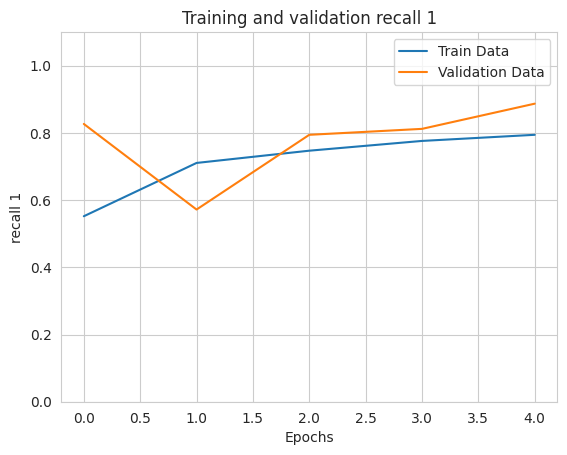

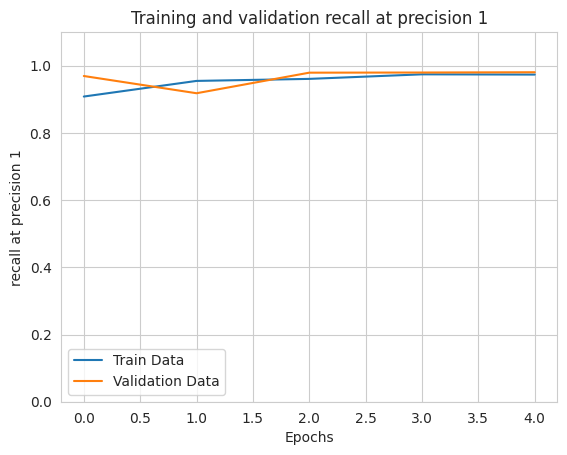

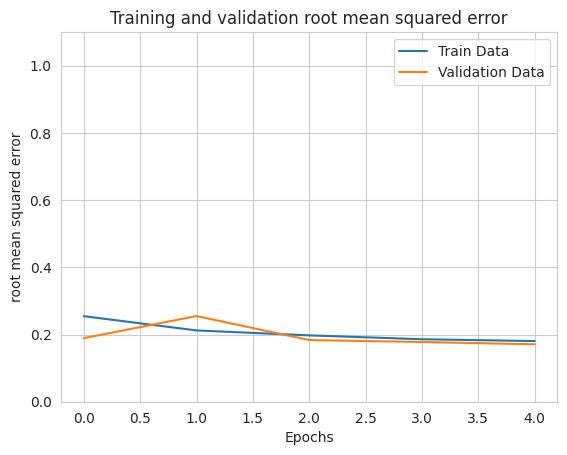

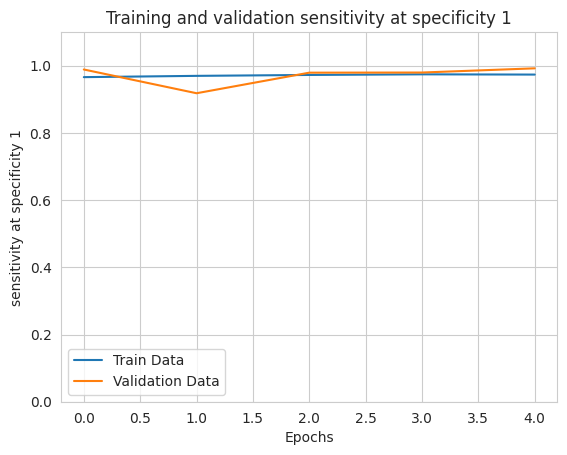

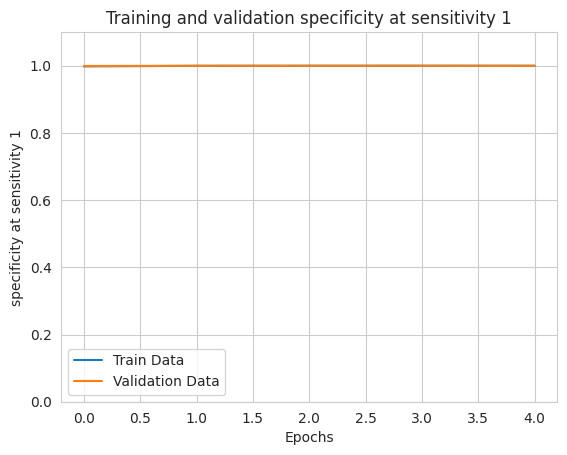

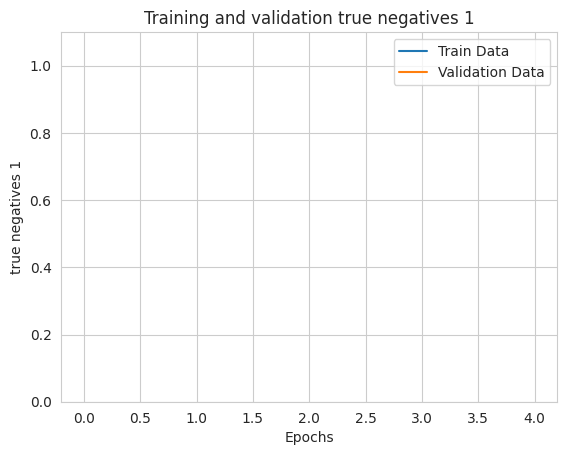

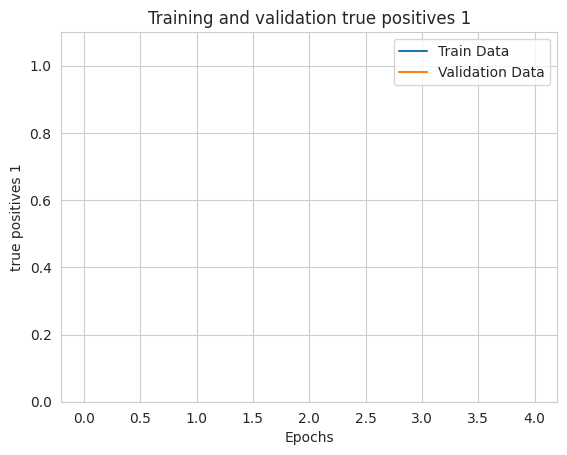

In [ ]:
plt.rcParams["axes.grid"] = True
for (
    train_metric_name,
    train_metric_value,
) in history_vgg_binary_normal_dme.history.items():
    if train_metric_name in display_metrics:
        val_metric_name = "val_" + train_metric_name

        train_metric_data = dict(
            zip(
                range(len(history_vgg_binary_normal_dme.history[train_metric_name])),
                history_vgg_binary_normal_dme.history[train_metric_name],
            )
        )
        val_metric_data = dict(
            zip(
                range(len(history_vgg_binary_normal_dme.history[val_metric_name])),
                history_vgg_binary_normal_dme.history[val_metric_name],
            )
        )
        sns.lineplot(
            data=train_metric_data,
            x=train_metric_data.keys(),
            y=train_metric_data.values(),
            label="Train Data",
        )
        sns.lineplot(
            data=val_metric_data,
            x=val_metric_data.keys(),
            y=val_metric_data.values(),
            label="Validation Data",
        )
        ax = plt.gca()  # we could display zoomed and non zoomed graphs
        ax.set_ylim(bottom=[0, 1.1])
        plt.xlabel(xlabel="Epochs")
        metric = train_metric_name.replace("_", " ")
        plt.ylabel(ylabel=metric)
        plt.title(label=f"Training and validation {metric}")
        plt.legend()
        plt.show()
        print("")

In [ ]:
# we evaluate our trained model with our test data
baseline_results_binary_normal_dme = model_octai_binary_normal_dme.evaluate(
    test_ds_binary_normal_dme
)

394/394 ━━━━━━━━━━━━━━━━━━━━ 65s 164ms/step - auc_1: 0.1833 - binary_accuracy: 0.9806 - false_negatives_1: 15.9873 - false_positives_1: 57.0709 - loss: 0.0652 - mean_absolute_error: 0.0467 - precision_1: 0.1439 - precision_at_recall_1: 0.1844 - r2_score: 0.0944 - recall_1: 0.1625 - recall_at_precision_1: 0.1744 - root_mean_squared_error: 0.1234 - sensitivity_at_specificity_1: 0.1862 - specificity_at_sensitivity_1: 0.1872 - true_negatives_1: 2999.2734 - true_positives_1: 95.6076


In [ ]:
for name, value in zip(
    ["loss"] + [metric.name for metric in model_metrics_binary],
    baseline_results_binary_normal_dme,
):
    print(f"{name} : {value}")


loss : 0.12990935146808624
binary_accuracy : 0.9546031951904297
true_positives_1 : 974.0
true_negatives_1 : 5040.0
false_positives_1 : 100.0
false_negatives_1 : 186.0
auc_1 : 0.9758721590042114
precision_1 : 0.9068901538848877
recall_1 : 0.8396551609039307
precision_at_recall_1 : 0.9953343868255615
recall_at_precision_1 : 0.9655172228813171
sensitivity_at_specificity_1 : 0.992241382598877
specificity_at_sensitivity_1 : 0.9994163513183594
mean_absolute_error : 0.07422685623168945
r2_score : 0.7631834149360657
root_mean_squared_error : 0.18861493468284607


In [ ]:
# we compute predictions to compute additional metrics
predictions_binary_normal_dme = model_octai_binary_normal_dme.predict(test_ds_binary_normal_dme)

394/394 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step


In [ ]:
true_classes_binary_normal_dme = tensorflow.concat(values=[y for _, y in test_ds_binary_normal_dme], axis=0)
predictions_binary_normal_dme = tensorflow.concat([item for item in predictions_binary_normal_dme], axis = 0)
predictions_binary_normal_dme = np.rint(predictions_binary_normal_dme).astype(int)

In [ ]:
# we compute the confusition matrix
cm_normalized_binary_normal_dme = confusion_matrix(
    y_true=true_classes_binary_normal_dme, y_pred=predictions_binary_normal_dme, normalize="true",
)
cm_binary_normal_dme = confusion_matrix(y_true=true_classes_binary_normal_dme, y_pred=predictions_binary_normal_dme)

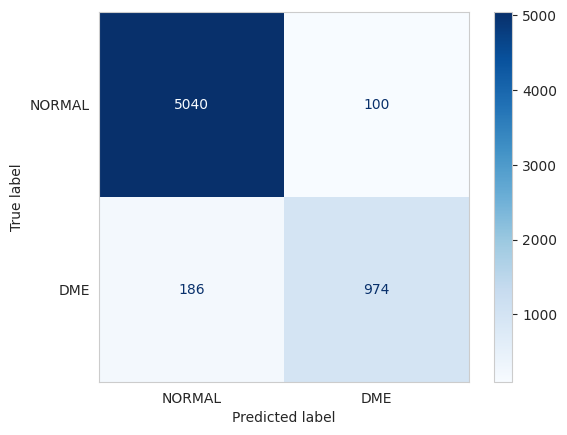

In [ ]:
# we print the confusion matrix
plt.rcParams["axes.grid"] = False
disp = ConfusionMatrixDisplay(confusion_matrix=cm_binary_normal_dme,display_labels=test_ds_binary_normal_dme.class_names)
disp = disp.plot(cmap=plt.cm.Blues)
plt.show()

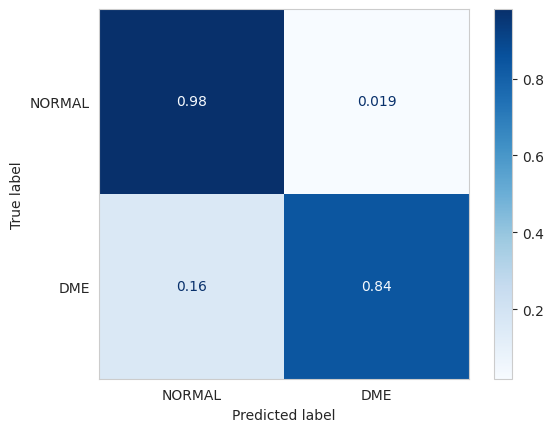

In [ ]:
# we print the confusion matrix normalised
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_normalized_binary_normal_dme, display_labels=test_ds_binary_normal_dme.class_names
)
disp = disp.plot(cmap=plt.cm.Blues)
plt.show()

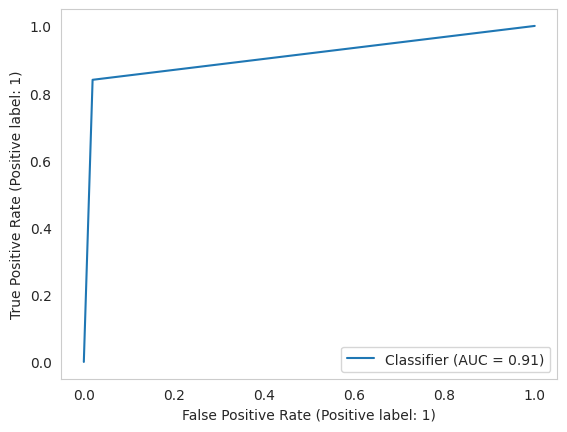

In [ ]:
RocCurveDisplay.from_predictions(true_classes_binary_normal_dme, predictions_binary_normal_dme)

In [ ]:
# we compute the cohen_kapp score
cohen_kappa_binary_normal_dme = cohen_kappa_score(y1=true_classes_binary_normal_dme, y2=predictions_binary_normal_dme)

#we diplay various metrics
for metric_idx, metric in enumerate(model_metrics_binary):
  if isinstance(metric,TruePositives):
    tp = baseline_results_binary_normal_dme[metric_idx+1]
  if isinstance(metric,TrueNegatives):
    tn = baseline_results_binary_normal_dme[metric_idx+1]
  if isinstance(metric,FalsePositives):
    fp = baseline_results_binary_normal_dme[metric_idx+1]
  if isinstance(metric,FalseNegatives):
    fn = baseline_results_binary_normal_dme[metric_idx+1]

_sensibility = tp/(tp+fn)
_specificity = tn/(tn+fp)

print(f"TruePositives : {tp}")
print(f"TrueNegatives : {tn}")
print(f"FalsePositives : {fp}")
print(f"FalseNegatives : {fn}")
print(f"Sensibility : {_sensibility:.2%}")
print(f"Specificity : {_specificity:.2%}")
print(f"VPP : {tp/(tp+fp):.2%}")
print(f"VPN : {tn/(tn+fn):.2%}")
print(f"RVP : {_sensibility/(1-_specificity)}")
print(f"RVP : {(1-_sensibility)/(_specificity)}")
print(f"cohen kappa : {cohen_kappa_binary_normal_dme}")



TruePositives : 974.0
TrueNegatives : 5040.0
FalsePositives : 100.0
FalseNegatives : 186.0
Sensibility : 83.97%
Specificity : 98.05%
VPP : 90.69%
VPN : 96.44%
RVP : 43.15827586206887
RVP : 0.16352627257799676
cohen kappa : 0.844437997948633
